# Main

# Analysis of dataset

/home/alexkstern/miniconda3/envs/credit_vae/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Train set shape: (12378, 32)
Validation set shape: (1547, 32)
Test set shape: (1548, 32)

Class distribution (fraud vs normal):
Train set:
0    96.946195
1     3.053805
Name: Class, dtype: float64

Validation set:
0    96.961862
1     3.038138
Name: Class, dtype: float64

Total fraud transactions: 425
Total normal transactions: 13500
Fraud ratio: 0.03052

Number of feature columns: 30


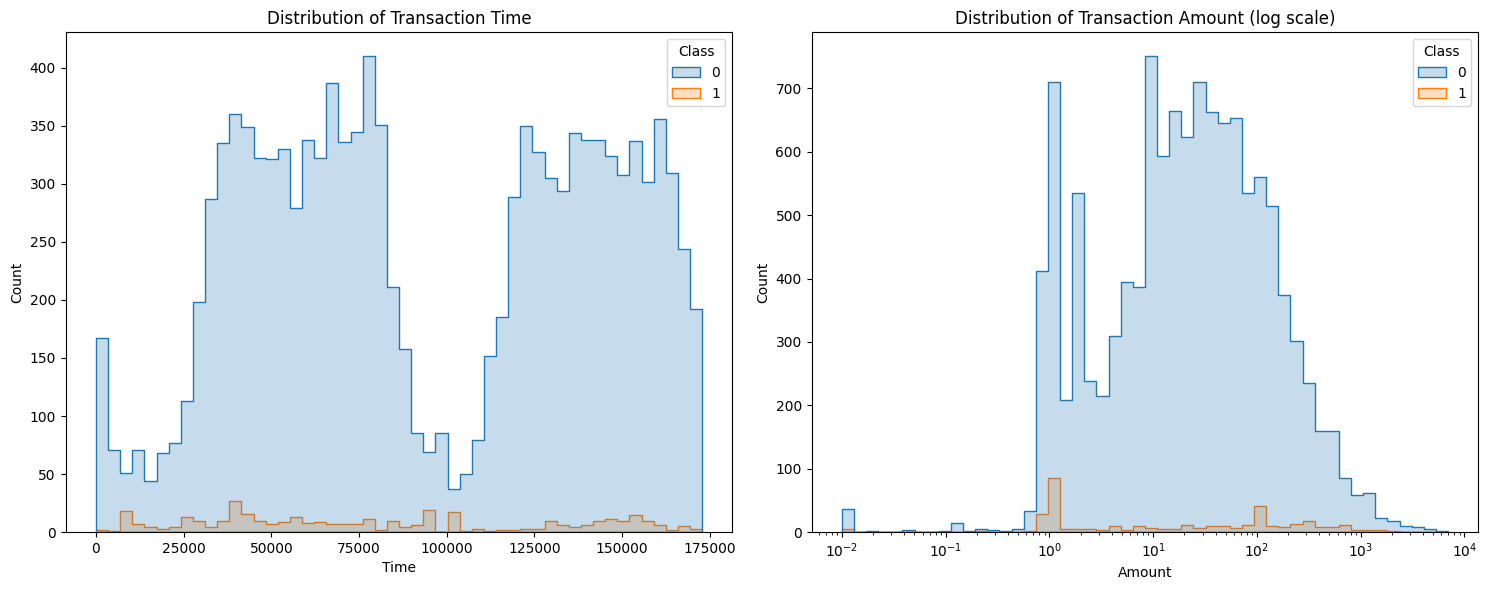

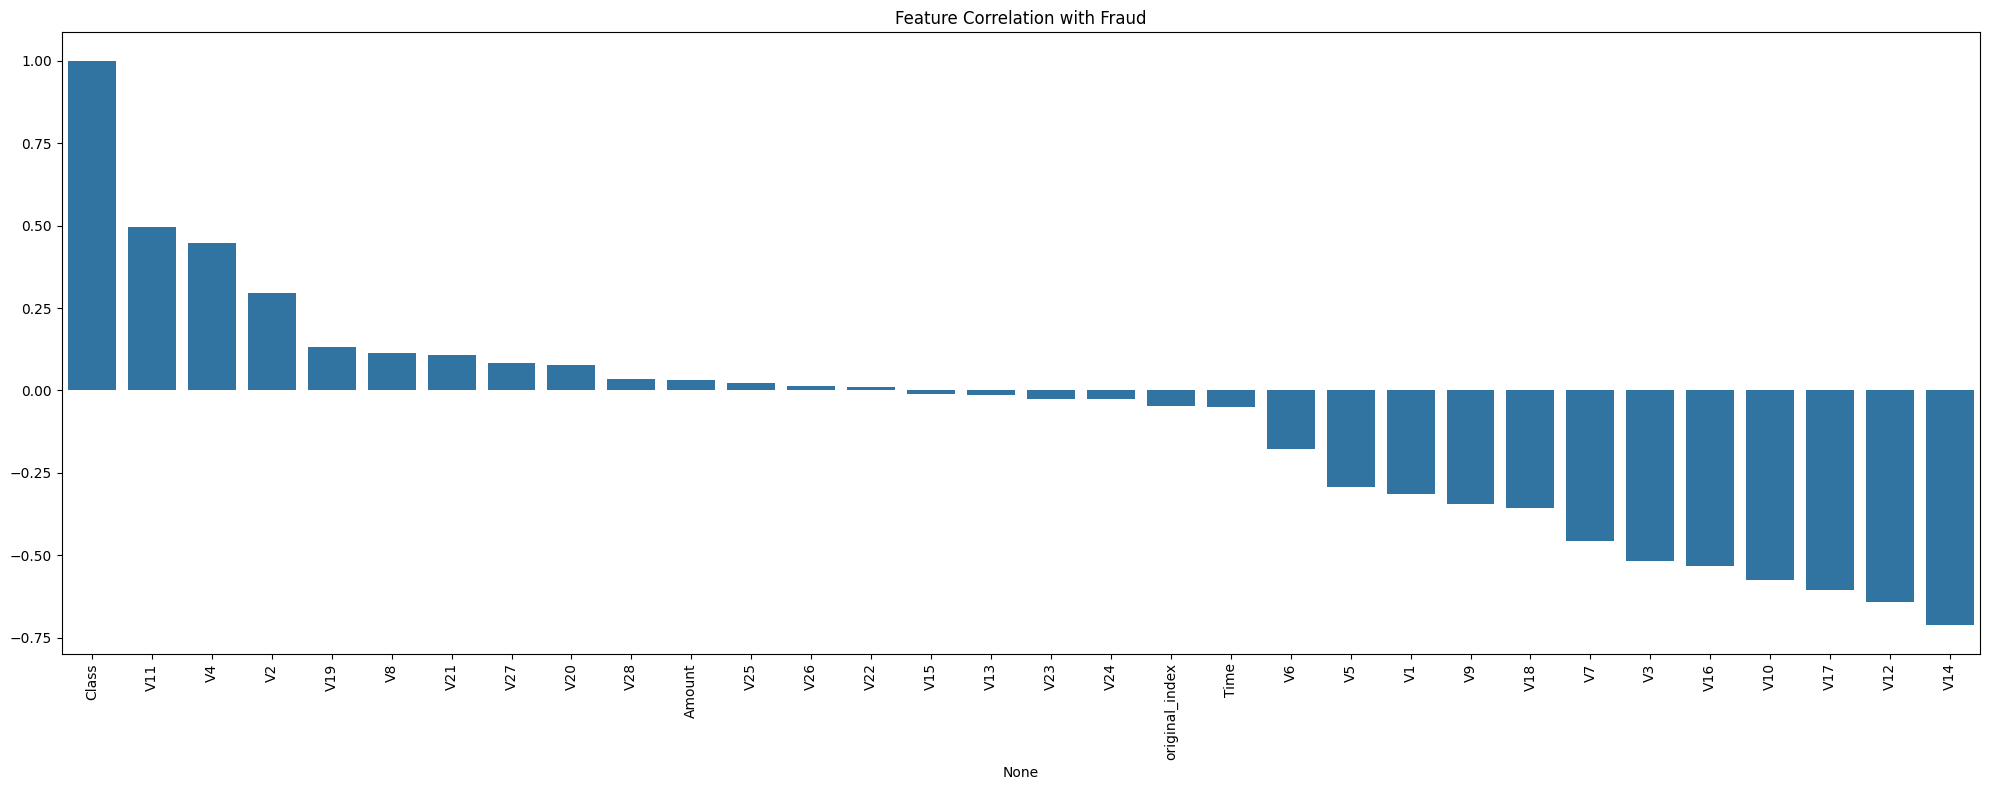

Approximate memory for batch size 8: 0.00 MB
Approximate memory for batch size 16: 0.00 MB
Approximate memory for batch size 32: 0.00 MB
Approximate memory for batch size 64: 0.01 MB
Approximate memory for batch size 128: 0.02 MB

Feature ranges (min, max, mean, std):
Time: min=12.00, max=172777.00, mean=93950.12, std=47455.06
Amount: min=0.00, max=6950.51, mean=89.01, std=241.90
V1: min=-46.86, max=2.45, mean=-0.12, std=2.33
V2: min=-45.61, max=22.06, mean=0.08, std=1.89
V3: min=-31.10, max=4.03, mean=-0.16, std=2.13
V4: min=-4.59, max=13.14, mean=0.14, std=1.65
V5: min=-22.11, max=20.90, mean=-0.08, std=1.68
V6: min=-14.43, max=16.36, mean=-0.05, std=1.35
V7: min=-43.56, max=24.66, mean=-0.14, std=1.82
V8: min=-41.04, max=20.01, mean=0.03, std=1.49
V9: min=-13.32, max=8.43, mean=-0.07, std=1.22
V10: min=-24.59, max=15.24, mean=-0.15, std=1.58
V11: min=-3.42, max=12.02, mean=0.10, std=1.24
V12: min=-18.55, max=4.07, mean=-0.17, std=1.58
V13: min=-3.62, max=4.37, mean=-0.00, std=1.00
V

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sklearn.model_selection import train_test_split

# Load the dataset
dataset = load_dataset("stanpony/european_credit_card_fraud_dataset")

# Convert to pandas DataFrame for easier analysis
train_df = pd.DataFrame(dataset['train'])
valid_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset.get('test', pd.DataFrame()))

# Basic dataset information
print(f"Train set shape: {train_df.shape}")
print(f"Validation set shape: {valid_df.shape}")
print(f"Test set shape: {test_df.shape if 'test' in dataset else 'No test set available'}")

# Class distribution
print("\nClass distribution (fraud vs normal):")
print("Train set:")
print(train_df['Class'].value_counts(normalize=True) * 100)
print("\nValidation set:")
print(valid_df['Class'].value_counts(normalize=True) * 100)

# Count total number of samples in each class
total_fraud = train_df[train_df['Class'] == 1].shape[0] + valid_df[valid_df['Class'] == 1].shape[0]
total_normal = train_df[train_df['Class'] == 0].shape[0] + valid_df[valid_df['Class'] == 0].shape[0]
print(f"\nTotal fraud transactions: {total_fraud}")
print(f"Total normal transactions: {total_normal}")
print(f"Fraud ratio: {total_fraud/(total_fraud+total_normal):.5f}")

# Feature information
feature_cols = [col for col in train_df.columns if col not in ['original_index', 'Class']]
num_features = len(feature_cols)
print(f"\nNumber of feature columns: {num_features}")

# Distribution of 'Time' and 'Amount'
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=train_df, x='Time', hue='Class', bins=50, element='step')
plt.title('Distribution of Transaction Time')

plt.subplot(1, 2, 2)
sns.histplot(data=train_df, x='Amount', hue='Class', bins=50, element='step', log_scale=True)
plt.title('Distribution of Transaction Amount (log scale)')
plt.tight_layout()
plt.show()

# Feature correlation with fraud
plt.figure(figsize=(20, 8))
correlation = train_df.corr()['Class'].sort_values(ascending=False)
sns.barplot(x=correlation.index, y=correlation.values)
plt.xticks(rotation=90)
plt.title('Feature Correlation with Fraud')
plt.tight_layout()
plt.show()

# Memory requirements for different batch sizes
batch_sizes = [8, 16, 32, 64, 128]
for batch_size in batch_sizes:
    # Approximate memory for a batch (assuming float32 precision)
    batch_memory_MB = (batch_size * train_df.shape[1] * 4) / (1024 * 1024)
    print(f"Approximate memory for batch size {batch_size}: {batch_memory_MB:.2f} MB")

# Check feature ranges for normalization
print("\nFeature ranges (min, max, mean, std):")
for col in ['Time', 'Amount'] + [f'V{i}' for i in range(1, 29)]:
    if col in train_df.columns:
        min_val = train_df[col].min()
        max_val = train_df[col].max()
        mean_val = train_df[col].mean()
        std_val = train_df[col].std()
        print(f"{col}: min={min_val:.2f}, max={max_val:.2f}, mean={mean_val:.2f}, std={std_val:.2f}")

# Train Fraud

## Conv VAE

### Fraud

In [1]:
import os
import torch
import torch.optim as optim
import numpy as np
import random

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Import required modules
from models.conv_vae_model import ConvVae, vae_loss_function, print_num_params
from trainer.trainer_vae import VAETrainer
from dataloader.dataloader import load_fraud_data, load_config
from utils.model_saver import save_model, get_save_directory
from utils.wandb_logger import WandBLogger
from utils.evaluation_utils import extract_recon_loss

# Build the config path
config_path = "configs/conv_vae/fraud_conv_vae.config"

# Load configuration
import configparser
config_parser = configparser.ConfigParser()
config_parser.read(config_path)
conv_vae_config = config_parser["Conv_VAE"]

# Create config dictionary for WandB
config_dict = {}
for section in config_parser.sections():
    config_dict[section] = dict(config_parser[section])

# Initialize WandB logger
wandb_logger = WandBLogger(config_dict)

# Load data
config_dict = load_config(config_path)
data = load_fraud_data(config_path=config_path)
dataloaders = data['dataloaders']
input_dim = data['input_dim']

# Create model
model = ConvVae(conv_vae_config)
print_num_params(model)

# Training parameters
lr = config_parser["Trainer"].getfloat("lr")
num_epochs = config_parser["Trainer"].getint("num_epochs")

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = vae_loss_function


# Create trainer
trainer = VAETrainer(model, dataloaders, loss_fn, optimizer)

# Create save directory
save_dir = get_save_directory(config_path)
print(f"Models will be saved to: {save_dir}")

# Track best validation loss
best_val_loss = float('inf')
train_losses, val_losses = [], []

try:
    # Training loop
    for epoch in range(1, num_epochs + 1):
        train_loss = trainer.train_epoch()
        val_loss = trainer.validate_epoch()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Log to WandB (if enabled)
        try:
            train_batch = next(iter(dataloaders['train']))
            val_batch = next(iter(dataloaders['val']))
            train_recon_loss = extract_recon_loss(model, train_batch, trainer.device)
            val_recon_loss = extract_recon_loss(model, val_batch, trainer.device)
            wandb_logger.log_epoch(epoch, train_loss, val_loss, train_recon_loss, val_recon_loss)
        except Exception as e:
            wandb_logger.log_epoch(epoch, train_loss, val_loss)
        
        # Print progress
        print(f"Epoch {epoch}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            metadata = {'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss}
            model_path = save_model(model, save_dir, 'best_model.pt', metadata)
            print(f"New best validation loss: {val_loss:.4f}")
            wandb_logger.log_model(model_path, metadata)

    # Save final model if different from best
    if val_losses[-1] > best_val_loss:
        metadata = {'epoch': num_epochs, 'train_loss': train_losses[-1], 'val_loss': val_losses[-1]}
        save_model(model, save_dir, 'final_model.pt', metadata)

    print(f"Training complete. Best validation loss: {best_val_loss:.4f}")

except KeyboardInterrupt:
    print("\nTraining interrupted by user. Saving current state...")
    if len(train_losses) > 0:
        metadata = {
            'interrupted': True,
            'epoch': len(train_losses), 
            'train_loss': train_losses[-1],
            'val_loss': val_losses[-1] if len(val_losses) > 0 else None
        }
        save_model(model, save_dir, 'interrupted_model.pt', metadata)
        print(f"Interrupted model saved to {save_dir}")

except Exception as e:
    print(f"\nTraining failed with error: {e}")
    import traceback
    traceback.print_exc()
    
finally:
    # Clean up WandB
    try:
        wandb_logger.finish()
    except:
        pass
    print("Training session complete.")

/home/alexkstern/miniconda3/envs/credit_vae/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Initializing WandB run: conv-vae-fraud_20250324_170214 (Project: fraud-classification, Entity: alexkstern)


wandb: Currently logged in as: alexkstern (alexksternteam) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Loaded configuration from configs/conv_vae/fraud_conv_vae.config
Filtered dataset to class 1: 378 samples
Normalization statistics (calculated from class 1): {'Time': {'mean': 80790.48148148147, 'std': 48332.5139872635}, 'Amount': {'mean': 133.6764814814815, 'std': 276.3532237447719}}
Filtered dataset to class 1: 378 samples
Filtered dataset to class 1: 47 samples
Filtered dataset to class 1: 48 samples
Total number of trainable parameters: 12849
Models will be saved to: saved_models/conv_vae/fraud_conv_vae/20250324_170226


Epoch 1/200: Train Loss = 719.9456, Val Loss = 1060.0364
Model saved to saved_models/conv_vae/fraud_conv_vae/20250324_170226/best_model.pt
New best validation loss: 1060.0364


Epoch 2/200: Train Loss = 698.3836, Val Loss = 1028.7213
Model saved to saved_models/conv_vae/fraud_conv_vae/20250324_170226/best_model.pt
New best validation loss: 1028.7213


Epoch 3/200: Train Loss = 681.9674, Val Loss = 1024.1164
Model saved to saved_models/conv_vae/fraud_conv_vae/20250324_170226/best_model.pt
New best validation loss: 1024.1164


Epoch 4/200: Train Loss = 679.7273, Val Loss = 1023.0258
Model saved to saved_models/conv_vae/fraud_conv_vae/20250324_170226/best_model.pt
New best validation loss: 1023.0258


Epoch 5/200: Train Loss = 679.2075, Val Loss = 1022.7389
Model saved to saved_models/conv_vae/fraud_conv_vae/20250324_170226/best_model.pt
New best validation loss: 1022.7389


Epoch 6/200: Train Loss = 679.0843, Val Loss = 1022.5971
Model saved to saved_models/conv_vae/fraud_conv_vae/20250324_170226/best_model.pt
New best validation loss: 1022.5971


Epoch 7/200: Train Loss = 678.9854, Val Loss = 1022.4929
Model saved to saved_models/conv_vae/fraud_conv_vae/20250324_170226/best_model.pt
New best validation loss: 1022.4929


Epoch 8/200: Train Loss = 678.8467, Val Loss = 1022.2553
Model saved to saved_models/conv_vae/fraud_conv_vae/20250324_170226/best_model.pt
New best validation loss: 1022.2553


Epoch 9/200: Train Loss = 678.4371, Val Loss = 1021.2025
Model saved to saved_models/conv_vae/fraud_conv_vae/20250324_170226/best_model.pt
New best validation loss: 1021.2025


Epoch 10/200: Train Loss = 676.2190, Val Loss = 1015.7966
Model saved to saved_models/conv_vae/fraud_conv_vae/20250324_170226/best_model.pt
New best validation loss: 1015.7966


Epoch 11/200: Train Loss = 670.9716, Val Loss = 1009.9716
Model saved to saved_models/conv_vae/fraud_conv_vae/20250324_170226/best_model.pt
New best validation loss: 1009.9716


Epoch 12/200: Train Loss = 667.5797, Val Loss = 1007.3008
Model saved to saved_models/conv_vae/fraud_conv_vae/20250324_170226/best_model.pt
New best validation loss: 1007.3008


Epoch 13/200: Train Loss = 666.0899, Val Loss = 1006.8192
Model saved to saved_models/conv_vae/fraud_conv_vae/20250324_170226/best_model.pt
New best validation loss: 1006.8192


Epoch 14/200: Train Loss = 665.3280, Val Loss = 1006.0089
Model saved to saved_models/conv_vae/fraud_conv_vae/20250324_170226/best_model.pt
New best validation loss: 1006.0089


Epoch 15/200: Train Loss = 665.2035, Val Loss = 1005.4033
Model saved to saved_models/conv_vae/fraud_conv_vae/20250324_170226/best_model.pt
New best validation loss: 1005.4033


Epoch 16/200: Train Loss = 664.8942, Val Loss = 1006.0063


Epoch 17/200: Train Loss = 664.5601, Val Loss = 1005.6275


Epoch 18/200: Train Loss = 664.9377, Val Loss = 1004.6683
Model saved to saved_models/conv_vae/fraud_conv_vae/20250324_170226/best_model.pt
New best validation loss: 1004.6683


Epoch 19/200: Train Loss = 665.0310, Val Loss = 1006.7190


Epoch 20/200: Train Loss = 664.9049, Val Loss = 1006.3031


Epoch 21/200: Train Loss = 664.8342, Val Loss = 1006.2556


Epoch 22/200: Train Loss = 664.7934, Val Loss = 1006.3388


Epoch 23/200: Train Loss = 664.4183, Val Loss = 1005.9156


Epoch 24/200: Train Loss = 664.3843, Val Loss = 1005.8818


Epoch 25/200: Train Loss = 663.9937, Val Loss = 1004.3872
Model saved to saved_models/conv_vae/fraud_conv_vae/20250324_170226/best_model.pt
New best validation loss: 1004.3872


Epoch 26/200: Train Loss = 664.4970, Val Loss = 1004.5015


Epoch 27/200: Train Loss = 664.3511, Val Loss = 1004.2430
Model saved to saved_models/conv_vae/fraud_conv_vae/20250324_170226/best_model.pt
New best validation loss: 1004.2430


Epoch 28/200: Train Loss = 664.3156, Val Loss = 1005.9410


Epoch 29/200: Train Loss = 664.2795, Val Loss = 1004.0497
Model saved to saved_models/conv_vae/fraud_conv_vae/20250324_170226/best_model.pt
New best validation loss: 1004.0497


Epoch 30/200: Train Loss = 663.9667, Val Loss = 1004.3036


Epoch 31/200: Train Loss = 663.8302, Val Loss = 1003.9927
Model saved to saved_models/conv_vae/fraud_conv_vae/20250324_170226/best_model.pt
New best validation loss: 1003.9927


Epoch 32/200: Train Loss = 663.8307, Val Loss = 1003.6386
Model saved to saved_models/conv_vae/fraud_conv_vae/20250324_170226/best_model.pt
New best validation loss: 1003.6386


Epoch 33/200: Train Loss = 663.7300, Val Loss = 1003.5244
Model saved to saved_models/conv_vae/fraud_conv_vae/20250324_170226/best_model.pt
New best validation loss: 1003.5244


Epoch 34/200: Train Loss = 663.9452, Val Loss = 1003.9638


Epoch 35/200: Train Loss = 663.9163, Val Loss = 1003.5512


Epoch 36/200: Train Loss = 663.5820, Val Loss = 1003.5356


Epoch 37/200: Train Loss = 663.8916, Val Loss = 1003.6522


Epoch 38/200: Train Loss = 663.7004, Val Loss = 1004.5573


Epoch 39/200: Train Loss = 663.6487, Val Loss = 1003.7530


Epoch 40/200: Train Loss = 663.5960, Val Loss = 1003.7068


Epoch 41/200: Train Loss = 661.1386, Val Loss = 997.3209
Model saved to saved_models/conv_vae/fraud_conv_vae/20250324_170226/best_model.pt
New best validation loss: 997.3209


Epoch 42/200: Train Loss = 658.1180, Val Loss = 996.7160
Model saved to saved_models/conv_vae/fraud_conv_vae/20250324_170226/best_model.pt
New best validation loss: 996.7160


Epoch 43/200: Train Loss = 657.6180, Val Loss = 996.3248
Model saved to saved_models/conv_vae/fraud_conv_vae/20250324_170226/best_model.pt
New best validation loss: 996.3248


Epoch 44/200: Train Loss = 657.5160, Val Loss = 996.5247


Epoch 45/200: Train Loss = 657.4520, Val Loss = 996.2940
Model saved to saved_models/conv_vae/fraud_conv_vae/20250324_170226/best_model.pt
New best validation loss: 996.2940


Epoch 46/200: Train Loss = 657.3387, Val Loss = 995.9743
Model saved to saved_models/conv_vae/fraud_conv_vae/20250324_170226/best_model.pt
New best validation loss: 995.9743


Epoch 47/200: Train Loss = 657.3941, Val Loss = 995.8792
Model saved to saved_models/conv_vae/fraud_conv_vae/20250324_170226/best_model.pt
New best validation loss: 995.8792


Epoch 48/200: Train Loss = 657.2177, Val Loss = 996.2290


Epoch 49/200: Train Loss = 657.0332, Val Loss = 995.7754
Model saved to saved_models/conv_vae/fraud_conv_vae/20250324_170226/best_model.pt
New best validation loss: 995.7754


Epoch 50/200: Train Loss = 656.9012, Val Loss = 995.5143
Model saved to saved_models/conv_vae/fraud_conv_vae/20250324_170226/best_model.pt
New best validation loss: 995.5143


Epoch 51/200: Train Loss = 656.8439, Val Loss = 995.6416


Epoch 52/200: Train Loss = 656.8009, Val Loss = 995.8044


Epoch 53/200: Train Loss = 656.8423, Val Loss = 995.2848
Model saved to saved_models/conv_vae/fraud_conv_vae/20250324_170226/best_model.pt
New best validation loss: 995.2848


Epoch 54/200: Train Loss = 656.6178, Val Loss = 995.3823


Epoch 55/200: Train Loss = 656.8576, Val Loss = 995.2460
Model saved to saved_models/conv_vae/fraud_conv_vae/20250324_170226/best_model.pt
New best validation loss: 995.2460


Epoch 56/200: Train Loss = 656.6285, Val Loss = 995.1282
Model saved to saved_models/conv_vae/fraud_conv_vae/20250324_170226/best_model.pt
New best validation loss: 995.1282


Epoch 57/200: Train Loss = 656.7271, Val Loss = 995.2790


Epoch 58/200: Train Loss = 656.7803, Val Loss = 995.8224


Epoch 59/200: Train Loss = 656.8044, Val Loss = 995.1355


Epoch 60/200: Train Loss = 656.7023, Val Loss = 995.3201


Epoch 61/200: Train Loss = 656.6487, Val Loss = 995.0485
Model saved to saved_models/conv_vae/fraud_conv_vae/20250324_170226/best_model.pt
New best validation loss: 995.0485


Epoch 62/200: Train Loss = 656.7306, Val Loss = 995.0416
Model saved to saved_models/conv_vae/fraud_conv_vae/20250324_170226/best_model.pt
New best validation loss: 995.0416


Epoch 63/200: Train Loss = 656.7143, Val Loss = 995.0558


Epoch 64/200: Train Loss = 656.8056, Val Loss = 994.7598
Model saved to saved_models/conv_vae/fraud_conv_vae/20250324_170226/best_model.pt
New best validation loss: 994.7598


Epoch 65/200: Train Loss = 656.7612, Val Loss = 995.4308


Epoch 66/200: Train Loss = 656.6760, Val Loss = 995.3888


Epoch 67/200: Train Loss = 656.7848, Val Loss = 995.2742


Epoch 68/200: Train Loss = 656.8177, Val Loss = 995.3167


Epoch 69/200: Train Loss = 656.6277, Val Loss = 995.1651


Epoch 70/200: Train Loss = 656.5956, Val Loss = 994.9019


Epoch 71/200: Train Loss = 656.6959, Val Loss = 994.8537


Epoch 72/200: Train Loss = 656.6097, Val Loss = 995.2203


Epoch 73/200: Train Loss = 656.4747, Val Loss = 995.1041


Epoch 74/200: Train Loss = 656.5636, Val Loss = 994.9204


Epoch 75/200: Train Loss = 656.4147, Val Loss = 994.9915


Epoch 76/200: Train Loss = 656.6140, Val Loss = 995.2888


Epoch 77/200: Train Loss = 656.6015, Val Loss = 995.2981


Epoch 78/200: Train Loss = 656.6573, Val Loss = 995.1430


Epoch 79/200: Train Loss = 656.5100, Val Loss = 994.9546


Epoch 80/200: Train Loss = 656.5460, Val Loss = 994.7343
Model saved to saved_models/conv_vae/fraud_conv_vae/20250324_170226/best_model.pt
New best validation loss: 994.7343


Epoch 81/200: Train Loss = 656.5624, Val Loss = 995.2087


Epoch 82/200: Train Loss = 656.6686, Val Loss = 994.8499


Epoch 83/200: Train Loss = 656.5579, Val Loss = 994.8986


Epoch 84/200: Train Loss = 656.6754, Val Loss = 995.3899


Epoch 85/200: Train Loss = 656.4501, Val Loss = 995.1506


Epoch 86/200: Train Loss = 656.4504, Val Loss = 995.1476


Epoch 87/200: Train Loss = 656.5203, Val Loss = 994.9336


Epoch 88/200: Train Loss = 656.5990, Val Loss = 994.8936


Epoch 89/200: Train Loss = 656.5681, Val Loss = 995.3268


Epoch 90/200: Train Loss = 656.5207, Val Loss = 994.9870


Epoch 91/200: Train Loss = 656.5306, Val Loss = 995.0352


Epoch 92/200: Train Loss = 656.8418, Val Loss = 994.9627


Epoch 93/200: Train Loss = 656.4870, Val Loss = 994.9045


Epoch 94/200: Train Loss = 656.5655, Val Loss = 995.5939


Epoch 95/200: Train Loss = 656.6525, Val Loss = 994.8428


Epoch 96/200: Train Loss = 656.5179, Val Loss = 994.8878


Epoch 97/200: Train Loss = 656.7023, Val Loss = 994.9040


Epoch 98/200: Train Loss = 656.5166, Val Loss = 994.9264


Epoch 99/200: Train Loss = 656.5223, Val Loss = 995.2906


Epoch 100/200: Train Loss = 656.6978, Val Loss = 995.0182


Epoch 101/200: Train Loss = 656.6620, Val Loss = 995.2279


Epoch 102/200: Train Loss = 656.5994, Val Loss = 994.8593


Epoch 103/200: Train Loss = 656.4859, Val Loss = 994.9905


Epoch 104/200: Train Loss = 656.5435, Val Loss = 995.2075


Epoch 105/200: Train Loss = 656.5518, Val Loss = 995.0429


Epoch 106/200: Train Loss = 656.5391, Val Loss = 994.8918


Epoch 107/200: Train Loss = 656.4332, Val Loss = 994.8939


Epoch 108/200: Train Loss = 656.5497, Val Loss = 994.7724


Epoch 109/200: Train Loss = 656.4532, Val Loss = 994.5283
Model saved to saved_models/conv_vae/fraud_conv_vae/20250324_170226/best_model.pt
New best validation loss: 994.5283


Epoch 110/200: Train Loss = 656.5279, Val Loss = 994.8784


Epoch 111/200: Train Loss = 656.4854, Val Loss = 995.0560


Epoch 112/200: Train Loss = 656.5601, Val Loss = 994.8611


Epoch 113/200: Train Loss = 656.5711, Val Loss = 995.2092


Epoch 114/200: Train Loss = 656.5368, Val Loss = 995.1290


Epoch 115/200: Train Loss = 656.5513, Val Loss = 995.2577


Epoch 116/200: Train Loss = 656.5967, Val Loss = 994.7844


Epoch 117/200: Train Loss = 656.5126, Val Loss = 995.1066


Epoch 118/200: Train Loss = 656.5790, Val Loss = 995.2364


Epoch 119/200: Train Loss = 656.4814, Val Loss = 994.6505


Epoch 120/200: Train Loss = 656.4972, Val Loss = 994.9875


Epoch 121/200: Train Loss = 656.6491, Val Loss = 994.9915


Epoch 122/200: Train Loss = 656.5303, Val Loss = 995.0123


Epoch 123/200: Train Loss = 656.5420, Val Loss = 995.1191


Epoch 124/200: Train Loss = 656.5547, Val Loss = 995.1152


Epoch 125/200: Train Loss = 656.5498, Val Loss = 994.7687


Epoch 126/200: Train Loss = 656.5953, Val Loss = 995.0227


Epoch 127/200: Train Loss = 656.4927, Val Loss = 994.9646


Epoch 128/200: Train Loss = 656.5235, Val Loss = 995.1791


Epoch 129/200: Train Loss = 656.5019, Val Loss = 995.0068


Epoch 130/200: Train Loss = 656.5734, Val Loss = 994.7543


Epoch 131/200: Train Loss = 656.5762, Val Loss = 994.6356


Epoch 132/200: Train Loss = 656.6299, Val Loss = 995.1467


Epoch 133/200: Train Loss = 656.5560, Val Loss = 995.0371


Epoch 134/200: Train Loss = 656.5584, Val Loss = 994.8805


Epoch 135/200: Train Loss = 656.6578, Val Loss = 994.8841


Epoch 136/200: Train Loss = 656.5102, Val Loss = 995.1782


Epoch 137/200: Train Loss = 656.5769, Val Loss = 994.9808


Epoch 138/200: Train Loss = 656.6354, Val Loss = 994.9511


Epoch 139/200: Train Loss = 656.6546, Val Loss = 995.1050


Epoch 140/200: Train Loss = 656.6304, Val Loss = 994.9344


Epoch 141/200: Train Loss = 656.5583, Val Loss = 995.1992


Epoch 142/200: Train Loss = 656.6069, Val Loss = 994.6886


Epoch 143/200: Train Loss = 656.5747, Val Loss = 994.8850


Epoch 144/200: Train Loss = 656.6713, Val Loss = 994.8723


Epoch 145/200: Train Loss = 656.5512, Val Loss = 995.3923


Epoch 146/200: Train Loss = 656.5752, Val Loss = 994.7855


Epoch 147/200: Train Loss = 656.5624, Val Loss = 994.7813


Epoch 148/200: Train Loss = 656.5001, Val Loss = 994.8991


Epoch 149/200: Train Loss = 656.5799, Val Loss = 994.7414


Epoch 150/200: Train Loss = 656.6971, Val Loss = 995.0467


Epoch 151/200: Train Loss = 656.5464, Val Loss = 995.0036


Epoch 152/200: Train Loss = 656.5276, Val Loss = 994.8369


Epoch 153/200: Train Loss = 656.5417, Val Loss = 994.9856


Epoch 154/200: Train Loss = 656.5344, Val Loss = 994.7761


Epoch 155/200: Train Loss = 656.6556, Val Loss = 994.9206


Epoch 156/200: Train Loss = 656.6800, Val Loss = 994.8227


Epoch 157/200: Train Loss = 656.4786, Val Loss = 994.9391


Epoch 158/200: Train Loss = 656.6348, Val Loss = 995.0890


Epoch 159/200: Train Loss = 656.6085, Val Loss = 994.9611


Epoch 160/200: Train Loss = 656.4627, Val Loss = 995.5087


Epoch 161/200: Train Loss = 656.5063, Val Loss = 995.0842


Epoch 162/200: Train Loss = 656.5103, Val Loss = 995.1168


Epoch 163/200: Train Loss = 656.5089, Val Loss = 994.9203


Epoch 164/200: Train Loss = 656.5639, Val Loss = 994.8367


Epoch 165/200: Train Loss = 656.5898, Val Loss = 995.1833


Epoch 166/200: Train Loss = 656.7033, Val Loss = 994.8741


Epoch 167/200: Train Loss = 656.6242, Val Loss = 994.8057


Epoch 168/200: Train Loss = 656.6054, Val Loss = 994.9862


Epoch 169/200: Train Loss = 656.3383, Val Loss = 995.0218


Epoch 170/200: Train Loss = 656.6202, Val Loss = 994.9628


Epoch 171/200: Train Loss = 656.6386, Val Loss = 995.0697


Epoch 172/200: Train Loss = 656.5432, Val Loss = 995.2743


Epoch 173/200: Train Loss = 656.5383, Val Loss = 994.9582


Epoch 174/200: Train Loss = 656.5482, Val Loss = 994.9747


Epoch 175/200: Train Loss = 656.6050, Val Loss = 995.0794


Epoch 176/200: Train Loss = 656.4970, Val Loss = 994.7597


Epoch 177/200: Train Loss = 656.5531, Val Loss = 994.9237


Epoch 178/200: Train Loss = 656.5081, Val Loss = 994.7488


Epoch 179/200: Train Loss = 656.4795, Val Loss = 995.0541


Epoch 180/200: Train Loss = 656.6135, Val Loss = 994.8951


Epoch 181/200: Train Loss = 656.6013, Val Loss = 994.7920


Epoch 182/200: Train Loss = 656.5004, Val Loss = 994.8705


Epoch 183/200: Train Loss = 656.5542, Val Loss = 994.9975


Epoch 184/200: Train Loss = 656.5136, Val Loss = 994.9992


Epoch 185/200: Train Loss = 656.6371, Val Loss = 994.7913


Epoch 186/200: Train Loss = 656.5893, Val Loss = 994.8390


Epoch 187/200: Train Loss = 656.6490, Val Loss = 994.9197


Epoch 188/200: Train Loss = 656.5490, Val Loss = 994.9378


Epoch 189/200: Train Loss = 656.5876, Val Loss = 994.7930


Epoch 190/200: Train Loss = 656.5293, Val Loss = 994.9552


Epoch 191/200: Train Loss = 656.4418, Val Loss = 995.2293


Epoch 192/200: Train Loss = 656.4302, Val Loss = 994.8637


Epoch 193/200: Train Loss = 656.4788, Val Loss = 994.9693


Epoch 194/200: Train Loss = 656.4014, Val Loss = 995.0529


Epoch 195/200: Train Loss = 656.5485, Val Loss = 994.9623


Epoch 196/200: Train Loss = 656.4738, Val Loss = 994.8317


Epoch 197/200: Train Loss = 656.6350, Val Loss = 994.9865


Epoch 198/200: Train Loss = 656.3691, Val Loss = 994.8775


Epoch 199/200: Train Loss = 656.5475, Val Loss = 994.8723


Epoch 200/200: Train Loss = 656.4023, Val Loss = 995.0145
Model saved to saved_models/conv_vae/fraud_conv_vae/20250324_170226/final_model.pt
Training complete. Best validation loss: 994.5283


epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
train/recon_loss,▂▅▅▆▃▅▆▃▁▆▅█▅▅▄▄▂▄▇▃▂▄▇▂▆▅▅▂▄▂▄▂▃▅▂▄▄█▆▄
train/total_loss,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/recon_loss,█▆▄▄▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/total_loss,██▄▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,200
train/recon_loss,12242.57617
train/total_loss,656.40235
val/recon_loss,28007.27344
val/total_loss,995.01446


Training session complete.


### TEST

In [1]:
import os
import torch
import torch.optim as optim
import numpy as np
import random
import configparser

# Import our modules
from models.conv_vae_model import ConvVae, vae_loss_function, print_num_params
from trainer.test_trainer_vae import VAETrainer  # Updated trainer
from dataloader.dataloader import load_fraud_data, load_config
from utils.model_saver import save_model, get_save_directory
from utils.wandb_logger_lr import WandBLogger
from utils.evaluation_utils import extract_recon_loss
from utils.lr_scheduler import create_scheduler  # New scheduler utility

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Build the config path
config_path = "configs/conv_vae/fraud_conv_vae_test.config"

# Load configuration
config_parser = configparser.ConfigParser()
config_parser.read(config_path)
conv_vae_config = config_parser["Conv_VAE"]
train_config = config_parser["Trainer"]

# Create config dictionary for WandB
config_dict = {}
for section in config_parser.sections():
    config_dict[section] = dict(config_parser[section])

# Initialize WandB logger
wandb_logger = WandBLogger(config_dict)

# Load data
config_dict = load_config(config_path)
data = load_fraud_data(config_path=config_path)
dataloaders = data['dataloaders']
input_dim = data['input_dim']

# Create model
model = ConvVae(conv_vae_config)
print("Model parameters:")
print_num_params(model)

# Training parameters
lr = train_config.getfloat("lr")
num_epochs = train_config.getint("num_epochs")
patience = train_config.getint("patience", 15)  # Get early stopping patience from config

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=lr)

# Create learning rate scheduler
scheduler = create_scheduler(train_config, optimizer)

# Define loss function
loss_fn = vae_loss_function

# Create trainer with scheduler
trainer = VAETrainer(model, dataloaders, loss_fn, optimizer, scheduler)

# Create save directory
save_dir = get_save_directory(config_path)
print(f"Models will be saved to: {save_dir}")

# Track best validation loss
best_val_loss = float('inf')
train_losses, val_losses = [], []
no_improve_count = 0  # Counter for early stopping

try:
    # Training loop
    for epoch in range(1, num_epochs + 1):
        train_loss = trainer.train_epoch()
        val_loss = trainer.validate_epoch()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        
        # Log to WandB (if enabled)
        try:
            train_batch = next(iter(dataloaders['train']))
            val_batch = next(iter(dataloaders['val']))
            train_recon_loss = extract_recon_loss(model, train_batch, trainer.device)
            val_recon_loss = extract_recon_loss(model, val_batch, trainer.device)
            
            # Add learning rate to logging
            wandb_logger.log_epoch(
                epoch, train_loss, val_loss, 
                train_recon_loss, val_recon_loss,
                learning_rate=current_lr
            )
        except Exception as e:
            print(f"WandB logging error: {e}")
            wandb_logger.log_epoch(epoch, train_loss, val_loss)
        
        # Print progress with learning rate
        print(f"Epoch {epoch}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, LR = {current_lr:.1e}")
        
        # Update scheduler based on validation loss
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        
        # Save best model and handle early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve_count = 0  # Reset counter when we see improvement
            
            # Save the best model
            metadata = {
                'epoch': epoch, 
                'train_loss': train_loss, 
                'val_loss': val_loss, 
                'learning_rate': current_lr
            }
            model_path = save_model(model, save_dir, 'best_model.pt', metadata)
            print(f"New best validation loss: {val_loss:.4f}")
            wandb_logger.log_model(model_path, metadata)
        else:
            no_improve_count += 1
            print(f"No improvement for {no_improve_count} epochs. Best val loss: {best_val_loss:.4f}")
            
            # Check if we should stop early
            if no_improve_count >= patience:
                print(f"Early stopping triggered after {epoch} epochs.")
                break

    # Save final model if different from best
    if val_losses[-1] > best_val_loss:
        metadata = {
            'epoch': epoch, 
            'train_loss': train_losses[-1], 
            'val_loss': val_losses[-1],
            'learning_rate': optimizer.param_groups[0]['lr']
        }
        save_model(model, save_dir, 'final_model.pt', metadata)

    print(f"Training complete. Best validation loss: {best_val_loss:.4f}")

except KeyboardInterrupt:
    print("\nTraining interrupted by user. Saving current state...")
    # Save interrupted model logic...
    metadata = {
        'epoch': epoch,
        'train_loss': train_losses[-1] if train_losses else None,
        'val_loss': val_losses[-1] if val_losses else None,
        'learning_rate': optimizer.param_groups[0]['lr'],
        'interrupted': True
    }
    save_model(model, save_dir, 'interrupted_model.pt', metadata)
    print(f"Saved interrupted model at epoch {epoch}")

except Exception as e:
    print(f"\nTraining failed with error: {e}")
    import traceback
    traceback.print_exc()
    
finally:
    # Clean up WandB
    try:
        wandb_logger.finish()
    except:
        pass
    print("Training session complete.")

/home/alexkstern/miniconda3/envs/credit_vae/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Initializing WandB run: conv-vae-fraud_20250324_151453 (Project: fraud-classification, Entity: alexkstern)


wandb: Currently logged in as: alexkstern (alexksternteam) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Loaded configuration from configs/conv_vae/fraud_conv_vae_test.config
Filtered dataset to class 1: 378 samples
Normalization statistics (calculated from class 1): {'Time': {'mean': 80790.48148148147, 'std': 48332.5139872635}, 'Amount': {'mean': 133.6764814814815, 'std': 276.3532237447719}}
Filtered dataset to class 1: 378 samples
Filtered dataset to class 1: 47 samples
Filtered dataset to class 1: 48 samples
Model parameters:
Total number of trainable parameters: 12849


/home/alexkstern/miniconda3/envs/credit_vae/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Models will be saved to: saved_models/conv_vae/fraud_conv_vae_test/20250324_151504


Epoch 1/200: Train Loss = 719.9456, Val Loss = 1060.0364, LR = 1.0e-03
Model saved to saved_models/conv_vae/fraud_conv_vae_test/20250324_151504/best_model.pt
New best validation loss: 1060.0364


Epoch 2/200: Train Loss = 698.3836, Val Loss = 1028.7213, LR = 1.0e-03
Model saved to saved_models/conv_vae/fraud_conv_vae_test/20250324_151504/best_model.pt
New best validation loss: 1028.7213


Epoch 3/200: Train Loss = 681.9674, Val Loss = 1024.1164, LR = 1.0e-03
Model saved to saved_models/conv_vae/fraud_conv_vae_test/20250324_151504/best_model.pt
New best validation loss: 1024.1164


Epoch 4/200: Train Loss = 679.7273, Val Loss = 1023.0258, LR = 1.0e-03
Model saved to saved_models/conv_vae/fraud_conv_vae_test/20250324_151504/best_model.pt
New best validation loss: 1023.0258


Epoch 5/200: Train Loss = 679.2075, Val Loss = 1022.7389, LR = 1.0e-03
Model saved to saved_models/conv_vae/fraud_conv_vae_test/20250324_151504/best_model.pt
New best validation loss: 1022.7389


Epoch 6/200: Train Loss = 679.0843, Val Loss = 1022.5971, LR = 1.0e-03
Model saved to saved_models/conv_vae/fraud_conv_vae_test/20250324_151504/best_model.pt
New best validation loss: 1022.5971


Epoch 7/200: Train Loss = 678.9854, Val Loss = 1022.4929, LR = 1.0e-03
Model saved to saved_models/conv_vae/fraud_conv_vae_test/20250324_151504/best_model.pt
New best validation loss: 1022.4929


Epoch 8/200: Train Loss = 678.8467, Val Loss = 1022.2553, LR = 1.0e-03
Model saved to saved_models/conv_vae/fraud_conv_vae_test/20250324_151504/best_model.pt
New best validation loss: 1022.2553


Epoch 9/200: Train Loss = 678.4371, Val Loss = 1021.2025, LR = 1.0e-03
Model saved to saved_models/conv_vae/fraud_conv_vae_test/20250324_151504/best_model.pt
New best validation loss: 1021.2025


Epoch 10/200: Train Loss = 676.2190, Val Loss = 1015.7966, LR = 1.0e-03
Model saved to saved_models/conv_vae/fraud_conv_vae_test/20250324_151504/best_model.pt
New best validation loss: 1015.7966


Epoch 11/200: Train Loss = 670.9716, Val Loss = 1009.9716, LR = 1.0e-03
Model saved to saved_models/conv_vae/fraud_conv_vae_test/20250324_151504/best_model.pt
New best validation loss: 1009.9716


Epoch 12/200: Train Loss = 667.5797, Val Loss = 1007.3008, LR = 1.0e-03
Model saved to saved_models/conv_vae/fraud_conv_vae_test/20250324_151504/best_model.pt
New best validation loss: 1007.3008


Epoch 13/200: Train Loss = 666.0899, Val Loss = 1006.8192, LR = 1.0e-03
Model saved to saved_models/conv_vae/fraud_conv_vae_test/20250324_151504/best_model.pt
New best validation loss: 1006.8192


Epoch 14/200: Train Loss = 665.3280, Val Loss = 1006.0089, LR = 1.0e-03
Model saved to saved_models/conv_vae/fraud_conv_vae_test/20250324_151504/best_model.pt
New best validation loss: 1006.0089


Epoch 15/200: Train Loss = 665.2035, Val Loss = 1005.4033, LR = 1.0e-03
Model saved to saved_models/conv_vae/fraud_conv_vae_test/20250324_151504/best_model.pt
New best validation loss: 1005.4033


Epoch 16/200: Train Loss = 664.8942, Val Loss = 1006.0063, LR = 1.0e-03
No improvement for 1 epochs. Best val loss: 1005.4033


Epoch 17/200: Train Loss = 664.5601, Val Loss = 1005.6275, LR = 1.0e-03
No improvement for 2 epochs. Best val loss: 1005.4033


Epoch 18/200: Train Loss = 664.9377, Val Loss = 1004.6683, LR = 1.0e-03
Model saved to saved_models/conv_vae/fraud_conv_vae_test/20250324_151504/best_model.pt
New best validation loss: 1004.6683


Epoch 19/200: Train Loss = 665.0310, Val Loss = 1006.7190, LR = 1.0e-03
No improvement for 1 epochs. Best val loss: 1004.6683


Epoch 20/200: Train Loss = 664.9049, Val Loss = 1006.3031, LR = 1.0e-03
No improvement for 2 epochs. Best val loss: 1004.6683


Epoch 21/200: Train Loss = 664.8342, Val Loss = 1006.2556, LR = 1.0e-03
No improvement for 3 epochs. Best val loss: 1004.6683


Epoch 22/200: Train Loss = 664.7934, Val Loss = 1006.3388, LR = 1.0e-03
No improvement for 4 epochs. Best val loss: 1004.6683


Epoch 23/200: Train Loss = 664.4183, Val Loss = 1005.9156, LR = 1.0e-03
No improvement for 5 epochs. Best val loss: 1004.6683


Epoch 24/200: Train Loss = 664.3843, Val Loss = 1005.8818, LR = 1.0e-03
No improvement for 6 epochs. Best val loss: 1004.6683


Epoch 25/200: Train Loss = 663.9937, Val Loss = 1004.3872, LR = 1.0e-03
Model saved to saved_models/conv_vae/fraud_conv_vae_test/20250324_151504/best_model.pt
New best validation loss: 1004.3872


Epoch 26/200: Train Loss = 664.4970, Val Loss = 1004.5015, LR = 1.0e-03
No improvement for 1 epochs. Best val loss: 1004.3872


Epoch 27/200: Train Loss = 664.3511, Val Loss = 1004.2430, LR = 1.0e-03
Model saved to saved_models/conv_vae/fraud_conv_vae_test/20250324_151504/best_model.pt
New best validation loss: 1004.2430


Epoch 28/200: Train Loss = 664.3156, Val Loss = 1005.9410, LR = 1.0e-03
No improvement for 1 epochs. Best val loss: 1004.2430


Epoch 29/200: Train Loss = 664.2795, Val Loss = 1004.0497, LR = 1.0e-03
Model saved to saved_models/conv_vae/fraud_conv_vae_test/20250324_151504/best_model.pt
New best validation loss: 1004.0497


Epoch 30/200: Train Loss = 663.9667, Val Loss = 1004.3036, LR = 1.0e-03
No improvement for 1 epochs. Best val loss: 1004.0497


Epoch 31/200: Train Loss = 663.8302, Val Loss = 1003.9927, LR = 1.0e-03
Model saved to saved_models/conv_vae/fraud_conv_vae_test/20250324_151504/best_model.pt
New best validation loss: 1003.9927


Epoch 32/200: Train Loss = 663.8307, Val Loss = 1003.6386, LR = 1.0e-03
Model saved to saved_models/conv_vae/fraud_conv_vae_test/20250324_151504/best_model.pt
New best validation loss: 1003.6386


Epoch 33/200: Train Loss = 663.7300, Val Loss = 1003.5244, LR = 1.0e-03
Model saved to saved_models/conv_vae/fraud_conv_vae_test/20250324_151504/best_model.pt
New best validation loss: 1003.5244


Epoch 34/200: Train Loss = 663.9452, Val Loss = 1003.9638, LR = 1.0e-03
No improvement for 1 epochs. Best val loss: 1003.5244


Epoch 35/200: Train Loss = 663.9163, Val Loss = 1003.5512, LR = 1.0e-03
No improvement for 2 epochs. Best val loss: 1003.5244


Epoch 36/200: Train Loss = 663.5820, Val Loss = 1003.5356, LR = 1.0e-03
No improvement for 3 epochs. Best val loss: 1003.5244


Epoch 37/200: Train Loss = 663.8916, Val Loss = 1003.6522, LR = 1.0e-03
No improvement for 4 epochs. Best val loss: 1003.5244


Epoch 38/200: Train Loss = 663.7004, Val Loss = 1004.5573, LR = 1.0e-03
No improvement for 5 epochs. Best val loss: 1003.5244


Epoch 39/200: Train Loss = 663.6487, Val Loss = 1003.7530, LR = 1.0e-03
No improvement for 6 epochs. Best val loss: 1003.5244


Epoch 40/200: Train Loss = 663.5960, Val Loss = 1003.7068, LR = 1.0e-03
No improvement for 7 epochs. Best val loss: 1003.5244


Epoch 41/200: Train Loss = 661.1386, Val Loss = 997.3209, LR = 1.0e-03
Model saved to saved_models/conv_vae/fraud_conv_vae_test/20250324_151504/best_model.pt
New best validation loss: 997.3209


Epoch 42/200: Train Loss = 658.1180, Val Loss = 996.7160, LR = 1.0e-03
Model saved to saved_models/conv_vae/fraud_conv_vae_test/20250324_151504/best_model.pt
New best validation loss: 996.7160


Epoch 43/200: Train Loss = 657.6180, Val Loss = 996.3248, LR = 1.0e-03
Model saved to saved_models/conv_vae/fraud_conv_vae_test/20250324_151504/best_model.pt
New best validation loss: 996.3248


Epoch 44/200: Train Loss = 657.5160, Val Loss = 996.5247, LR = 1.0e-03
No improvement for 1 epochs. Best val loss: 996.3248


Epoch 45/200: Train Loss = 657.4520, Val Loss = 996.2940, LR = 1.0e-03
Model saved to saved_models/conv_vae/fraud_conv_vae_test/20250324_151504/best_model.pt
New best validation loss: 996.2940


Epoch 46/200: Train Loss = 657.3387, Val Loss = 995.9743, LR = 1.0e-03
Model saved to saved_models/conv_vae/fraud_conv_vae_test/20250324_151504/best_model.pt
New best validation loss: 995.9743


Epoch 47/200: Train Loss = 657.3941, Val Loss = 995.8792, LR = 1.0e-03
Model saved to saved_models/conv_vae/fraud_conv_vae_test/20250324_151504/best_model.pt
New best validation loss: 995.8792


Epoch 48/200: Train Loss = 657.2177, Val Loss = 996.2290, LR = 1.0e-03
No improvement for 1 epochs. Best val loss: 995.8792


Epoch 49/200: Train Loss = 657.0332, Val Loss = 995.7754, LR = 1.0e-03
Model saved to saved_models/conv_vae/fraud_conv_vae_test/20250324_151504/best_model.pt
New best validation loss: 995.7754


Epoch 50/200: Train Loss = 656.9012, Val Loss = 995.5143, LR = 1.0e-03
Model saved to saved_models/conv_vae/fraud_conv_vae_test/20250324_151504/best_model.pt
New best validation loss: 995.5143


Epoch 51/200: Train Loss = 656.8439, Val Loss = 995.6416, LR = 1.0e-03
No improvement for 1 epochs. Best val loss: 995.5143


Epoch 52/200: Train Loss = 656.8009, Val Loss = 995.8044, LR = 1.0e-03
No improvement for 2 epochs. Best val loss: 995.5143


Epoch 53/200: Train Loss = 656.8423, Val Loss = 995.2848, LR = 1.0e-03
Model saved to saved_models/conv_vae/fraud_conv_vae_test/20250324_151504/best_model.pt
New best validation loss: 995.2848


Epoch 54/200: Train Loss = 656.6178, Val Loss = 995.3823, LR = 1.0e-03
No improvement for 1 epochs. Best val loss: 995.2848


Epoch 55/200: Train Loss = 656.8576, Val Loss = 995.2460, LR = 1.0e-03
Model saved to saved_models/conv_vae/fraud_conv_vae_test/20250324_151504/best_model.pt
New best validation loss: 995.2460


Epoch 56/200: Train Loss = 656.6285, Val Loss = 995.1282, LR = 1.0e-03
Model saved to saved_models/conv_vae/fraud_conv_vae_test/20250324_151504/best_model.pt
New best validation loss: 995.1282


Epoch 57/200: Train Loss = 656.7271, Val Loss = 995.2790, LR = 1.0e-03
No improvement for 1 epochs. Best val loss: 995.1282


Epoch 58/200: Train Loss = 656.7803, Val Loss = 995.8224, LR = 1.0e-03
No improvement for 2 epochs. Best val loss: 995.1282


Epoch 59/200: Train Loss = 656.8044, Val Loss = 995.1355, LR = 1.0e-03
No improvement for 3 epochs. Best val loss: 995.1282


Epoch 60/200: Train Loss = 656.7023, Val Loss = 995.3201, LR = 1.0e-03
No improvement for 4 epochs. Best val loss: 995.1282


Epoch 61/200: Train Loss = 656.6487, Val Loss = 995.0485, LR = 1.0e-03
Model saved to saved_models/conv_vae/fraud_conv_vae_test/20250324_151504/best_model.pt
New best validation loss: 995.0485


Epoch 62/200: Train Loss = 656.7306, Val Loss = 995.0416, LR = 1.0e-03
Model saved to saved_models/conv_vae/fraud_conv_vae_test/20250324_151504/best_model.pt
New best validation loss: 995.0416


Epoch 63/200: Train Loss = 656.7143, Val Loss = 995.0558, LR = 1.0e-03
No improvement for 1 epochs. Best val loss: 995.0416


Epoch 64/200: Train Loss = 656.8056, Val Loss = 994.7598, LR = 1.0e-03
Model saved to saved_models/conv_vae/fraud_conv_vae_test/20250324_151504/best_model.pt
New best validation loss: 994.7598


Epoch 65/200: Train Loss = 656.7612, Val Loss = 995.4308, LR = 1.0e-03
No improvement for 1 epochs. Best val loss: 994.7598


Epoch 66/200: Train Loss = 656.6760, Val Loss = 995.3888, LR = 1.0e-03
No improvement for 2 epochs. Best val loss: 994.7598


Epoch 67/200: Train Loss = 656.7848, Val Loss = 995.2742, LR = 1.0e-03
No improvement for 3 epochs. Best val loss: 994.7598


Epoch 68/200: Train Loss = 656.8177, Val Loss = 995.3167, LR = 1.0e-03
No improvement for 4 epochs. Best val loss: 994.7598


Epoch 69/200: Train Loss = 656.6277, Val Loss = 995.1651, LR = 1.0e-03
No improvement for 5 epochs. Best val loss: 994.7598


Epoch 70/200: Train Loss = 656.5956, Val Loss = 994.9019, LR = 1.0e-03
No improvement for 6 epochs. Best val loss: 994.7598


Epoch 71/200: Train Loss = 656.6959, Val Loss = 994.8537, LR = 1.0e-03
No improvement for 7 epochs. Best val loss: 994.7598


Epoch 72/200: Train Loss = 656.6097, Val Loss = 995.2203, LR = 1.0e-03
No improvement for 8 epochs. Best val loss: 994.7598


Epoch 73/200: Train Loss = 656.4747, Val Loss = 995.1041, LR = 1.0e-03
No improvement for 9 epochs. Best val loss: 994.7598


Epoch 74/200: Train Loss = 656.5636, Val Loss = 994.9204, LR = 1.0e-03
No improvement for 10 epochs. Best val loss: 994.7598


Epoch 75/200: Train Loss = 656.4147, Val Loss = 994.9915, LR = 1.0e-03
No improvement for 11 epochs. Best val loss: 994.7598


Epoch 76/200: Train Loss = 656.6140, Val Loss = 995.2888, LR = 1.0e-03
No improvement for 12 epochs. Best val loss: 994.7598


Epoch 77/200: Train Loss = 656.6015, Val Loss = 995.2981, LR = 1.0e-03
No improvement for 13 epochs. Best val loss: 994.7598


Epoch 78/200: Train Loss = 656.6573, Val Loss = 995.1430, LR = 1.0e-03
No improvement for 14 epochs. Best val loss: 994.7598


Epoch 79/200: Train Loss = 656.5100, Val Loss = 994.9546, LR = 1.0e-03
No improvement for 15 epochs. Best val loss: 994.7598


Epoch 80/200: Train Loss = 656.5460, Val Loss = 994.7343, LR = 1.0e-03
Model saved to saved_models/conv_vae/fraud_conv_vae_test/20250324_151504/best_model.pt
New best validation loss: 994.7343


Epoch 81/200: Train Loss = 656.5624, Val Loss = 995.2087, LR = 1.0e-03
No improvement for 1 epochs. Best val loss: 994.7343


Epoch 82/200: Train Loss = 656.6686, Val Loss = 994.8499, LR = 1.0e-03
No improvement for 2 epochs. Best val loss: 994.7343


Epoch 83/200: Train Loss = 656.5579, Val Loss = 994.8986, LR = 1.0e-03
No improvement for 3 epochs. Best val loss: 994.7343


Epoch 84/200: Train Loss = 656.6754, Val Loss = 995.3899, LR = 1.0e-03
No improvement for 4 epochs. Best val loss: 994.7343


Epoch 85/200: Train Loss = 656.4501, Val Loss = 995.1506, LR = 1.0e-03
No improvement for 5 epochs. Best val loss: 994.7343


Epoch 86/200: Train Loss = 656.4504, Val Loss = 995.1476, LR = 1.0e-03
No improvement for 6 epochs. Best val loss: 994.7343


Epoch 87/200: Train Loss = 656.5203, Val Loss = 994.9336, LR = 1.0e-03
No improvement for 7 epochs. Best val loss: 994.7343


Epoch 88/200: Train Loss = 656.5990, Val Loss = 994.8936, LR = 1.0e-03
No improvement for 8 epochs. Best val loss: 994.7343


Epoch 89/200: Train Loss = 656.5681, Val Loss = 995.3268, LR = 1.0e-03
No improvement for 9 epochs. Best val loss: 994.7343


Epoch 90/200: Train Loss = 656.5207, Val Loss = 994.9870, LR = 1.0e-03
No improvement for 10 epochs. Best val loss: 994.7343


Epoch 91/200: Train Loss = 656.5306, Val Loss = 995.0352, LR = 1.0e-03
No improvement for 11 epochs. Best val loss: 994.7343


Epoch 92/200: Train Loss = 656.8418, Val Loss = 994.9627, LR = 1.0e-03
No improvement for 12 epochs. Best val loss: 994.7343


Epoch 93/200: Train Loss = 656.4870, Val Loss = 994.9045, LR = 1.0e-03
No improvement for 13 epochs. Best val loss: 994.7343


Epoch 94/200: Train Loss = 656.5655, Val Loss = 995.5939, LR = 1.0e-03
No improvement for 14 epochs. Best val loss: 994.7343


Epoch 95/200: Train Loss = 656.6525, Val Loss = 994.8428, LR = 1.0e-03
No improvement for 15 epochs. Best val loss: 994.7343


Epoch 96/200: Train Loss = 656.4948, Val Loss = 994.8651, LR = 5.0e-04
No improvement for 16 epochs. Best val loss: 994.7343


Epoch 97/200: Train Loss = 656.6598, Val Loss = 994.8663, LR = 5.0e-04
No improvement for 17 epochs. Best val loss: 994.7343


Epoch 98/200: Train Loss = 656.4988, Val Loss = 994.8646, LR = 5.0e-04
No improvement for 18 epochs. Best val loss: 994.7343


Epoch 99/200: Train Loss = 656.4996, Val Loss = 995.2462, LR = 5.0e-04
No improvement for 19 epochs. Best val loss: 994.7343


Epoch 100/200: Train Loss = 656.6840, Val Loss = 994.9460, LR = 5.0e-04
No improvement for 20 epochs. Best val loss: 994.7343


Epoch 101/200: Train Loss = 656.6235, Val Loss = 995.5585, LR = 5.0e-04
No improvement for 21 epochs. Best val loss: 994.7343


Epoch 102/200: Train Loss = 656.5653, Val Loss = 994.8667, LR = 5.0e-04
No improvement for 22 epochs. Best val loss: 994.7343


Epoch 103/200: Train Loss = 656.4805, Val Loss = 994.9209, LR = 5.0e-04
No improvement for 23 epochs. Best val loss: 994.7343


Epoch 104/200: Train Loss = 656.5133, Val Loss = 995.1907, LR = 5.0e-04
No improvement for 24 epochs. Best val loss: 994.7343


Epoch 105/200: Train Loss = 656.5498, Val Loss = 995.0187, LR = 5.0e-04
No improvement for 25 epochs. Best val loss: 994.7343


Epoch 106/200: Train Loss = 656.5223, Val Loss = 994.8563, LR = 5.0e-04
No improvement for 26 epochs. Best val loss: 994.7343


Epoch 107/200: Train Loss = 656.4232, Val Loss = 994.8963, LR = 5.0e-04
No improvement for 27 epochs. Best val loss: 994.7343


Epoch 108/200: Train Loss = 656.5277, Val Loss = 994.7416, LR = 5.0e-04
No improvement for 28 epochs. Best val loss: 994.7343


Epoch 109/200: Train Loss = 656.4700, Val Loss = 994.5731, LR = 5.0e-04
Model saved to saved_models/conv_vae/fraud_conv_vae_test/20250324_151504/best_model.pt
New best validation loss: 994.5731


Epoch 110/200: Train Loss = 656.5172, Val Loss = 994.9077, LR = 5.0e-04
No improvement for 1 epochs. Best val loss: 994.5731


Epoch 111/200: Train Loss = 656.4949, Val Loss = 995.0793, LR = 5.0e-04
No improvement for 2 epochs. Best val loss: 994.5731


Epoch 112/200: Train Loss = 656.5528, Val Loss = 994.8167, LR = 5.0e-04
No improvement for 3 epochs. Best val loss: 994.5731


Epoch 113/200: Train Loss = 656.5300, Val Loss = 995.2583, LR = 5.0e-04
No improvement for 4 epochs. Best val loss: 994.5731


Epoch 114/200: Train Loss = 656.5404, Val Loss = 995.1365, LR = 5.0e-04
No improvement for 5 epochs. Best val loss: 994.5731


Epoch 115/200: Train Loss = 656.5656, Val Loss = 995.1083, LR = 5.0e-04
No improvement for 6 epochs. Best val loss: 994.5731


Epoch 116/200: Train Loss = 656.5685, Val Loss = 994.6995, LR = 5.0e-04
No improvement for 7 epochs. Best val loss: 994.5731


Epoch 117/200: Train Loss = 656.4877, Val Loss = 995.0170, LR = 5.0e-04
No improvement for 8 epochs. Best val loss: 994.5731


Epoch 118/200: Train Loss = 656.5299, Val Loss = 995.2109, LR = 5.0e-04
No improvement for 9 epochs. Best val loss: 994.5731


Epoch 119/200: Train Loss = 656.4605, Val Loss = 994.7272, LR = 5.0e-04
No improvement for 10 epochs. Best val loss: 994.5731


Epoch 120/200: Train Loss = 656.4706, Val Loss = 994.8454, LR = 5.0e-04
No improvement for 11 epochs. Best val loss: 994.5731


Epoch 121/200: Train Loss = 656.5838, Val Loss = 995.0134, LR = 5.0e-04
No improvement for 12 epochs. Best val loss: 994.5731


Epoch 122/200: Train Loss = 656.5105, Val Loss = 995.0152, LR = 5.0e-04
No improvement for 13 epochs. Best val loss: 994.5731


Epoch 123/200: Train Loss = 656.5280, Val Loss = 995.1361, LR = 5.0e-04
No improvement for 14 epochs. Best val loss: 994.5731


Epoch 124/200: Train Loss = 656.5342, Val Loss = 995.0491, LR = 5.0e-04
No improvement for 15 epochs. Best val loss: 994.5731


Epoch 125/200: Train Loss = 656.5195, Val Loss = 994.7928, LR = 5.0e-04
No improvement for 16 epochs. Best val loss: 994.5731


Epoch 126/200: Train Loss = 656.5294, Val Loss = 994.8775, LR = 5.0e-04
No improvement for 17 epochs. Best val loss: 994.5731


Epoch 127/200: Train Loss = 656.4737, Val Loss = 994.9061, LR = 5.0e-04
No improvement for 18 epochs. Best val loss: 994.5731


Epoch 128/200: Train Loss = 656.4986, Val Loss = 994.8945, LR = 5.0e-04
No improvement for 19 epochs. Best val loss: 994.5731


Epoch 129/200: Train Loss = 656.4926, Val Loss = 995.0780, LR = 5.0e-04
No improvement for 20 epochs. Best val loss: 994.5731


Epoch 130/200: Train Loss = 656.5141, Val Loss = 994.7355, LR = 5.0e-04
No improvement for 21 epochs. Best val loss: 994.5731


Epoch 131/200: Train Loss = 656.5522, Val Loss = 994.6198, LR = 5.0e-04
No improvement for 22 epochs. Best val loss: 994.5731


Epoch 132/200: Train Loss = 656.6868, Val Loss = 995.1160, LR = 5.0e-04
No improvement for 23 epochs. Best val loss: 994.5731


Epoch 133/200: Train Loss = 656.5177, Val Loss = 995.0117, LR = 5.0e-04
No improvement for 24 epochs. Best val loss: 994.5731


Epoch 134/200: Train Loss = 656.5704, Val Loss = 994.8840, LR = 5.0e-04
No improvement for 25 epochs. Best val loss: 994.5731


Epoch 135/200: Train Loss = 656.6790, Val Loss = 994.9094, LR = 5.0e-04
No improvement for 26 epochs. Best val loss: 994.5731


Epoch 136/200: Train Loss = 656.5012, Val Loss = 995.2580, LR = 5.0e-04
No improvement for 27 epochs. Best val loss: 994.5731


Epoch 137/200: Train Loss = 656.5972, Val Loss = 995.0297, LR = 5.0e-04
No improvement for 28 epochs. Best val loss: 994.5731


Epoch 138/200: Train Loss = 656.5440, Val Loss = 994.9827, LR = 5.0e-04
No improvement for 29 epochs. Best val loss: 994.5731


Epoch 139/200: Train Loss = 656.6484, Val Loss = 995.1330, LR = 5.0e-04
No improvement for 30 epochs. Best val loss: 994.5731


Epoch 140/200: Train Loss = 656.6212, Val Loss = 994.9309, LR = 5.0e-04
No improvement for 31 epochs. Best val loss: 994.5731


Epoch 141/200: Train Loss = 656.5822, Val Loss = 995.2217, LR = 2.5e-04
No improvement for 32 epochs. Best val loss: 994.5731


Epoch 142/200: Train Loss = 656.6028, Val Loss = 994.6856, LR = 2.5e-04
No improvement for 33 epochs. Best val loss: 994.5731


Epoch 143/200: Train Loss = 656.5712, Val Loss = 994.8620, LR = 2.5e-04
No improvement for 34 epochs. Best val loss: 994.5731


Epoch 144/200: Train Loss = 656.6935, Val Loss = 995.0856, LR = 2.5e-04
No improvement for 35 epochs. Best val loss: 994.5731


Epoch 145/200: Train Loss = 656.5070, Val Loss = 995.3799, LR = 2.5e-04
No improvement for 36 epochs. Best val loss: 994.5731


Epoch 146/200: Train Loss = 656.5696, Val Loss = 994.9091, LR = 2.5e-04
No improvement for 37 epochs. Best val loss: 994.5731


Epoch 147/200: Train Loss = 656.5630, Val Loss = 994.7967, LR = 2.5e-04
No improvement for 38 epochs. Best val loss: 994.5731


Epoch 148/200: Train Loss = 656.4846, Val Loss = 994.9199, LR = 2.5e-04
No improvement for 39 epochs. Best val loss: 994.5731


Epoch 149/200: Train Loss = 656.5685, Val Loss = 994.7917, LR = 2.5e-04
No improvement for 40 epochs. Best val loss: 994.5731


Epoch 150/200: Train Loss = 656.5135, Val Loss = 994.9528, LR = 2.5e-04
No improvement for 41 epochs. Best val loss: 994.5731


Epoch 151/200: Train Loss = 656.4263, Val Loss = 995.0096, LR = 2.5e-04
No improvement for 42 epochs. Best val loss: 994.5731


Epoch 152/200: Train Loss = 656.4486, Val Loss = 994.8950, LR = 2.5e-04
No improvement for 43 epochs. Best val loss: 994.5731


Epoch 153/200: Train Loss = 656.4421, Val Loss = 995.0173, LR = 2.5e-04
No improvement for 44 epochs. Best val loss: 994.5731


Epoch 154/200: Train Loss = 656.4641, Val Loss = 994.8236, LR = 2.5e-04
No improvement for 45 epochs. Best val loss: 994.5731


Epoch 155/200: Train Loss = 656.5595, Val Loss = 995.0860, LR = 2.5e-04
No improvement for 46 epochs. Best val loss: 994.5731


Epoch 156/200: Train Loss = 656.4761, Val Loss = 994.8223, LR = 2.5e-04
No improvement for 47 epochs. Best val loss: 994.5731


Epoch 157/200: Train Loss = 656.3620, Val Loss = 994.9380, LR = 2.5e-04
No improvement for 48 epochs. Best val loss: 994.5731


Epoch 158/200: Train Loss = 656.6155, Val Loss = 995.0022, LR = 2.5e-04
No improvement for 49 epochs. Best val loss: 994.5731


Epoch 159/200: Train Loss = 656.5382, Val Loss = 994.9575, LR = 2.5e-04
No improvement for 50 epochs. Best val loss: 994.5731


Epoch 160/200: Train Loss = 656.4660, Val Loss = 995.6316, LR = 2.5e-04
No improvement for 51 epochs. Best val loss: 994.5731


Epoch 161/200: Train Loss = 656.5189, Val Loss = 995.2038, LR = 2.5e-04
No improvement for 52 epochs. Best val loss: 994.5731


Epoch 162/200: Train Loss = 656.4106, Val Loss = 995.1603, LR = 2.5e-04
No improvement for 53 epochs. Best val loss: 994.5731


Epoch 163/200: Train Loss = 656.4872, Val Loss = 994.9884, LR = 2.5e-04
No improvement for 54 epochs. Best val loss: 994.5731


Epoch 164/200: Train Loss = 656.5212, Val Loss = 994.8673, LR = 2.5e-04
No improvement for 55 epochs. Best val loss: 994.5731


Epoch 165/200: Train Loss = 656.5931, Val Loss = 995.0840, LR = 2.5e-04
No improvement for 56 epochs. Best val loss: 994.5731


Epoch 166/200: Train Loss = 656.5875, Val Loss = 994.8099, LR = 2.5e-04
No improvement for 57 epochs. Best val loss: 994.5731


Epoch 167/200: Train Loss = 656.4231, Val Loss = 994.8120, LR = 2.5e-04
No improvement for 58 epochs. Best val loss: 994.5731


Epoch 168/200: Train Loss = 656.5553, Val Loss = 995.0306, LR = 2.5e-04
No improvement for 59 epochs. Best val loss: 994.5731


Epoch 169/200: Train Loss = 656.4505, Val Loss = 995.0330, LR = 2.5e-04
No improvement for 60 epochs. Best val loss: 994.5731
Early stopping triggered after 169 epochs.
Model saved to saved_models/conv_vae/fraud_conv_vae_test/20250324_151504/final_model.pt
Training complete. Best validation loss: 994.5731


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
learning_rate,████████████████████████▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁▁
train/recon_loss,▅▃▃▅▃▆▅▃▅█▅▇▃▁▆▅▃▄▅▅▆▅▂▃▆▆▅▅▆▆▃▄▄▇▃▇▅▂▂▂
train/total_loss,█▇▇▄▃▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/recon_loss,█▄▄▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/total_loss,█▄▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,169
learning_rate,0.00025
train/recon_loss,13470.44336
train/total_loss,656.4505
val/recon_loss,28013.10156


Training session complete.


### Normal

In [1]:
import os
import torch
import torch.optim as optim
import numpy as np
import random

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Import required modules
from models.conv_vae_model import ConvVae, vae_loss_function, print_num_params
from trainer.trainer_vae import VAETrainer
from dataloader.dataloader import load_fraud_data, load_config
from utils.model_saver import save_model, get_save_directory
from utils.wandb_logger import WandBLogger
from utils.evaluation_utils import extract_recon_loss

# Build the config path
config_path = "configs/conv_vae/normal_conv_vae.config"

# Load configuration
import configparser
config_parser = configparser.ConfigParser()
config_parser.read(config_path)
conv_vae_config = config_parser["Conv_VAE"]

# Create config dictionary for WandB
config_dict = {}
for section in config_parser.sections():
    config_dict[section] = dict(config_parser[section])

# Initialize WandB logger
wandb_logger = WandBLogger(config_dict)

# Load data
config_dict = load_config(config_path)
data = load_fraud_data(config_path=config_path)
dataloaders = data['dataloaders']
input_dim = data['input_dim']

# Create model
model = ConvVae(conv_vae_config)
print_num_params(model)

# Training parameters
lr = config_parser["Trainer"].getfloat("lr")
num_epochs = config_parser["Trainer"].getint("num_epochs")

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = vae_loss_function

# Create trainer
trainer = VAETrainer(model, dataloaders, loss_fn, optimizer)

# Create save directory
save_dir = get_save_directory(config_path)
print(f"Models will be saved to: {save_dir}")

# Track best validation loss
best_val_loss = float('inf')
train_losses, val_losses = [], []

try:
    # Training loop
    for epoch in range(1, num_epochs + 1):
        train_loss = trainer.train_epoch()
        val_loss = trainer.validate_epoch()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Log to WandB (if enabled)
        try:
            train_batch = next(iter(dataloaders['train']))
            val_batch = next(iter(dataloaders['val']))
            train_recon_loss = extract_recon_loss(model, train_batch, trainer.device)
            val_recon_loss = extract_recon_loss(model, val_batch, trainer.device)
            wandb_logger.log_epoch(epoch, train_loss, val_loss, train_recon_loss, val_recon_loss)
        except Exception as e:
            wandb_logger.log_epoch(epoch, train_loss, val_loss)
        
        # Print progress
        print(f"Epoch {epoch}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            metadata = {'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss}
            model_path = save_model(model, save_dir, 'best_model.pt', metadata)
            print(f"New best validation loss: {val_loss:.4f}")
            wandb_logger.log_model(model_path, metadata)

    # Save final model if different from best
    if val_losses[-1] > best_val_loss:
        metadata = {'epoch': num_epochs, 'train_loss': train_losses[-1], 'val_loss': val_losses[-1]}
        save_model(model, save_dir, 'final_model.pt', metadata)

    print(f"Training complete. Best validation loss: {best_val_loss:.4f}")

except KeyboardInterrupt:
    print("\nTraining interrupted by user. Saving current state...")
    if len(train_losses) > 0:
        metadata = {
            'interrupted': True,
            'epoch': len(train_losses), 
            'train_loss': train_losses[-1],
            'val_loss': val_losses[-1] if len(val_losses) > 0 else None
        }
        save_model(model, save_dir, 'interrupted_model.pt', metadata)
        print(f"Interrupted model saved to {save_dir}")

except Exception as e:
    print(f"\nTraining failed with error: {e}")
    import traceback
    traceback.print_exc()
    
finally:
    # Clean up WandB
    try:
        wandb_logger.finish()
    except:
        pass
    print("Training session complete.")

/home/alexkstern/miniconda3/envs/credit_vae/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Initializing WandB run: conv-vae-normal_20250313_175704 (Project: fraud-classification, Entity: alexkstern)


wandb: Currently logged in as: alexkstern (alexksternteam) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Loaded configuration from configs/conv_vae/normal_conv_vae.config
Filtered dataset to class 0: 12000 samples
Normalization statistics (calculated from class 0): {'Time': {'mean': 94364.65358333333, 'std': 47365.815157589255}, 'Amount': {'mean': 87.60478666666666, 'std': 240.59403081682598}}
Filtered dataset to class 0: 12000 samples
Filtered dataset to class 0: 1500 samples
Filtered dataset to class 0: 1500 samples
Total number of trainable parameters: 62727
Models will be saved to: saved_models/conv_vae/normal_conv_vae/20250313_175713


Epoch 1/30: Train Loss = 31.6793, Val Loss = 32.5413
Model saved to saved_models/conv_vae/normal_conv_vae/20250313_175713/best_model.pt
New best validation loss: 32.5413


Epoch 2/30: Train Loss = 31.5506, Val Loss = 32.5407
Model saved to saved_models/conv_vae/normal_conv_vae/20250313_175713/best_model.pt
New best validation loss: 32.5407


Epoch 3/30: Train Loss = 31.5506, Val Loss = 32.5412


Epoch 4/30: Train Loss = 31.5506, Val Loss = 32.5413


Epoch 5/30: Train Loss = 31.5506, Val Loss = 32.5413


Epoch 6/30: Train Loss = 31.5505, Val Loss = 32.5413


Epoch 7/30: Train Loss = 31.5505, Val Loss = 32.5413


Epoch 8/30: Train Loss = 31.5505, Val Loss = 32.5413


Epoch 9/30: Train Loss = 31.5505, Val Loss = 32.5413


Epoch 10/30: Train Loss = 31.5505, Val Loss = 32.5413


Epoch 11/30: Train Loss = 31.5505, Val Loss = 32.5413


Epoch 12/30: Train Loss = 31.5505, Val Loss = 32.5413


Epoch 13/30: Train Loss = 31.5505, Val Loss = 32.5413


Epoch 14/30: Train Loss = 31.5505, Val Loss = 32.5413


Epoch 15/30: Train Loss = 31.5505, Val Loss = 32.5413


Epoch 16/30: Train Loss = 31.5505, Val Loss = 32.5413


Epoch 17/30: Train Loss = 31.5505, Val Loss = 32.5413


Epoch 18/30: Train Loss = 31.5505, Val Loss = 32.5413


Epoch 19/30: Train Loss = 31.5505, Val Loss = 32.5413


Epoch 20/30: Train Loss = 31.5505, Val Loss = 32.5413


Epoch 21/30: Train Loss = 31.5505, Val Loss = 32.5413


Epoch 22/30: Train Loss = 31.5505, Val Loss = 32.5413


Epoch 23/30: Train Loss = 31.5505, Val Loss = 32.5413


Epoch 24/30: Train Loss = 31.5505, Val Loss = 32.5413


Epoch 25/30: Train Loss = 31.5505, Val Loss = 32.5413


Epoch 26/30: Train Loss = 31.5505, Val Loss = 32.5413


Epoch 27/30: Train Loss = 31.5505, Val Loss = 32.5413


Epoch 28/30: Train Loss = 31.5505, Val Loss = 32.5413


Epoch 29/30: Train Loss = 31.5505, Val Loss = 32.5413


Epoch 30/30: Train Loss = 31.5505, Val Loss = 32.5413
Model saved to saved_models/conv_vae/normal_conv_vae/20250313_175713/final_model.pt
Training complete. Best validation loss: 32.5407


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/recon_loss,▃█▂▂▂▂▂▃▃▃▃▂▄▁▂▁▂▂▂▁▁▁▂▁▂▃▂▂▂▂
train/total_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/recon_loss,█▁▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
val/total_loss,█▁▇███████████████████████████
epoch,30
train/recon_loss,170.05019
train/total_loss,31.55054
val/recon_loss,199.38646
val/total_loss,32.54126


Training session complete.


## Transformer VAE

### Fraud

In [2]:
import os
import torch
import torch.optim as optim
import numpy as np
import random

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Import required modules
from models.transformer_vae_model import TransformerVae, vae_loss_function, print_num_params
from trainer.trainer_vae import VAETrainer
from dataloader.dataloader import load_fraud_data, load_config
from utils.model_saver import save_model, get_save_directory
from utils.wandb_logger import WandBLogger
from utils.evaluation_utils import extract_recon_loss

# Build the config path
config_path = "configs/transformer_vae/fraud_transformer_vae.config"

# Load configuration
import configparser
config_parser = configparser.ConfigParser()
config_parser.read(config_path)
transformer_vae_config = config_parser["Transformer_VAE"]

# Create config dictionary for WandB
config_dict = {}
for section in config_parser.sections():
    config_dict[section] = dict(config_parser[section])

# Initialize WandB logger
wandb_logger = WandBLogger(config_dict)

# Load data
config_dict = load_config(config_path)
data = load_fraud_data(config_path=config_path)
dataloaders = data['dataloaders']
input_dim = data['input_dim']

# Create model
model = TransformerVae(transformer_vae_config)
print_num_params(model)

# Training parameters
lr = config_parser["Trainer"].getfloat("lr")
num_epochs = config_parser["Trainer"].getint("num_epochs")

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = vae_loss_function

# Create trainer
trainer = VAETrainer(model, dataloaders, loss_fn, optimizer)

# Create save directory
save_dir = get_save_directory(config_path)
print(f"Models will be saved to: {save_dir}")

# Track best validation loss
best_val_loss = float('inf')
train_losses, val_losses = [], []

try:
    # Training loop
    for epoch in range(1, num_epochs + 1):
        train_loss = trainer.train_epoch()
        val_loss = trainer.validate_epoch()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Log to WandB (if enabled)
        try:
            train_batch = next(iter(dataloaders['train']))
            val_batch = next(iter(dataloaders['val']))
            train_recon_loss = extract_recon_loss(model, train_batch, trainer.device)
            val_recon_loss = extract_recon_loss(model, val_batch, trainer.device)
            wandb_logger.log_epoch(epoch, train_loss, val_loss, train_recon_loss, val_recon_loss)
        except Exception as e:
            wandb_logger.log_epoch(epoch, train_loss, val_loss)
        
        # Print progress
        print(f"Epoch {epoch}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            metadata = {'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss}
            model_path = save_model(model, save_dir, 'best_model.pt', metadata)
            print(f"New best validation loss: {val_loss:.4f}")
            wandb_logger.log_model(model_path, metadata)

    # Save final model if different from best
    if val_losses[-1] > best_val_loss:
        metadata = {'epoch': num_epochs, 'train_loss': train_losses[-1], 'val_loss': val_losses[-1]}
        save_model(model, save_dir, 'final_model.pt', metadata)

    print(f"Training complete. Best validation loss: {best_val_loss:.4f}")

except KeyboardInterrupt:
    print("\nTraining interrupted by user. Saving current state...")
    if len(train_losses) > 0:
        metadata = {
            'interrupted': True,
            'epoch': len(train_losses), 
            'train_loss': train_losses[-1],
            'val_loss': val_losses[-1] if len(val_losses) > 0 else None
        }
        save_model(model, save_dir, 'interrupted_model.pt', metadata)
        print(f"Interrupted model saved to {save_dir}")

except Exception as e:
    print(f"\nTraining failed with error: {e}")
    import traceback
    traceback.print_exc()
    
finally:
    # Clean up WandB
    try:
        wandb_logger.finish()
    except:
        pass
    print("Training session complete.")

Initializing WandB run: transformer-vae-fraud_20250324_165428 (Project: fraud-classification, Entity: alexkstern)


Loaded configuration from configs/transformer_vae/fraud_transformer_vae.config
Filtered dataset to class 1: 378 samples
Normalization statistics (calculated from class 1): {'Time': {'mean': 80790.48148148147, 'std': 48332.5139872635}, 'Amount': {'mean': 133.6764814814815, 'std': 276.3532237447719}}
Filtered dataset to class 1: 378 samples
Filtered dataset to class 1: 47 samples
Filtered dataset to class 1: 48 samples
Total number of trainable parameters: 214823
Models will be saved to: saved_models/transformer_vae/fraud_transformer_vae/20250324_165441


Epoch 1/100: Train Loss = 688.0492, Val Loss = 1023.3890
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1023.3890


Epoch 2/100: Train Loss = 679.5704, Val Loss = 1023.0395
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1023.0395


Epoch 3/100: Train Loss = 679.3714, Val Loss = 1022.9141
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.9141


Epoch 4/100: Train Loss = 679.2783, Val Loss = 1022.8381
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.8381


Epoch 5/100: Train Loss = 679.2214, Val Loss = 1022.7867
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.7867


Epoch 6/100: Train Loss = 679.1804, Val Loss = 1022.7482
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.7482


Epoch 7/100: Train Loss = 679.1494, Val Loss = 1022.7180
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.7180


Epoch 8/100: Train Loss = 679.1236, Val Loss = 1022.6931
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.6931


Epoch 9/100: Train Loss = 679.1018, Val Loss = 1022.6734
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.6734


Epoch 10/100: Train Loss = 679.0855, Val Loss = 1022.6558
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.6558


Epoch 11/100: Train Loss = 679.0709, Val Loss = 1022.6411
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.6411


Epoch 12/100: Train Loss = 679.0580, Val Loss = 1022.6293
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.6293


Epoch 13/100: Train Loss = 679.0482, Val Loss = 1022.6191
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.6191


Epoch 14/100: Train Loss = 679.0389, Val Loss = 1022.6100
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.6100


Epoch 15/100: Train Loss = 679.0314, Val Loss = 1022.6025
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.6025


Epoch 16/100: Train Loss = 679.0244, Val Loss = 1022.5959
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5959


Epoch 17/100: Train Loss = 679.0187, Val Loss = 1022.5902
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5902


Epoch 18/100: Train Loss = 679.0135, Val Loss = 1022.5851
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5851


Epoch 19/100: Train Loss = 679.0092, Val Loss = 1022.5804
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5804


Epoch 20/100: Train Loss = 679.0052, Val Loss = 1022.5765
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5765


Epoch 21/100: Train Loss = 679.0017, Val Loss = 1022.5728
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5728


Epoch 22/100: Train Loss = 678.9985, Val Loss = 1022.5699
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5699


Epoch 23/100: Train Loss = 678.9957, Val Loss = 1022.5670
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5670


Epoch 24/100: Train Loss = 678.9933, Val Loss = 1022.5645
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5645


Epoch 25/100: Train Loss = 678.9909, Val Loss = 1022.5622
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5622


Epoch 26/100: Train Loss = 678.9889, Val Loss = 1022.5601
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5601


Epoch 27/100: Train Loss = 678.9871, Val Loss = 1022.5582
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5582


Epoch 28/100: Train Loss = 678.9854, Val Loss = 1022.5566
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5566


Epoch 29/100: Train Loss = 678.9839, Val Loss = 1022.5550
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5550


Epoch 30/100: Train Loss = 678.9825, Val Loss = 1022.5536
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5536


Epoch 31/100: Train Loss = 678.9812, Val Loss = 1022.5523
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5523


Epoch 32/100: Train Loss = 678.9801, Val Loss = 1022.5512
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5512


Epoch 33/100: Train Loss = 678.9789, Val Loss = 1022.5500
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5500


Epoch 34/100: Train Loss = 678.9780, Val Loss = 1022.5490
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5490


Epoch 35/100: Train Loss = 678.9769, Val Loss = 1022.5481
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5481


Epoch 36/100: Train Loss = 678.9761, Val Loss = 1022.5473
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5473


Epoch 37/100: Train Loss = 678.9754, Val Loss = 1022.5465
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5465


Epoch 38/100: Train Loss = 678.9746, Val Loss = 1022.5457
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5457


Epoch 39/100: Train Loss = 678.9740, Val Loss = 1022.5450
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5450


Epoch 40/100: Train Loss = 678.9733, Val Loss = 1022.5443
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5443


Epoch 41/100: Train Loss = 678.9727, Val Loss = 1022.5438
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5438


Epoch 42/100: Train Loss = 678.9722, Val Loss = 1022.5432
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5432


Epoch 43/100: Train Loss = 678.9716, Val Loss = 1022.5427
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5427


Epoch 44/100: Train Loss = 678.9711, Val Loss = 1022.5422
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5422


Epoch 45/100: Train Loss = 678.9707, Val Loss = 1022.5417
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5417


Epoch 46/100: Train Loss = 678.9703, Val Loss = 1022.5413
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5413


Epoch 47/100: Train Loss = 678.9699, Val Loss = 1022.5408
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5408


Epoch 48/100: Train Loss = 678.9695, Val Loss = 1022.5404
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5404


Epoch 49/100: Train Loss = 678.9691, Val Loss = 1022.5401
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5401


Epoch 50/100: Train Loss = 678.9688, Val Loss = 1022.5398
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5398


Epoch 51/100: Train Loss = 678.9685, Val Loss = 1022.5394
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5394


Epoch 52/100: Train Loss = 678.9682, Val Loss = 1022.5391
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5391


Epoch 53/100: Train Loss = 678.9679, Val Loss = 1022.5388
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5388


Epoch 54/100: Train Loss = 678.9676, Val Loss = 1022.5386
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5386


Epoch 55/100: Train Loss = 678.9673, Val Loss = 1022.5383
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5383


Epoch 56/100: Train Loss = 678.9671, Val Loss = 1022.5381
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5381


Epoch 57/100: Train Loss = 678.9669, Val Loss = 1022.5379
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5379


Epoch 58/100: Train Loss = 678.9667, Val Loss = 1022.5377
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5377


Epoch 59/100: Train Loss = 678.9665, Val Loss = 1022.5374
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5374


Epoch 60/100: Train Loss = 678.9662, Val Loss = 1022.5372
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5372


Epoch 61/100: Train Loss = 678.9661, Val Loss = 1022.5370
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5370


Epoch 62/100: Train Loss = 678.9658, Val Loss = 1022.5368
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5368


Epoch 63/100: Train Loss = 678.9657, Val Loss = 1022.5367
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5367


Epoch 64/100: Train Loss = 678.9656, Val Loss = 1022.5365
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5365


Epoch 65/100: Train Loss = 678.9654, Val Loss = 1022.5364
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5364


Epoch 66/100: Train Loss = 678.9652, Val Loss = 1022.5361
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5361


Epoch 67/100: Train Loss = 678.9651, Val Loss = 1022.5360
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5360


Epoch 68/100: Train Loss = 678.9650, Val Loss = 1022.5359
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5359


Epoch 69/100: Train Loss = 678.9648, Val Loss = 1022.5358
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5358


Epoch 70/100: Train Loss = 678.9647, Val Loss = 1022.5357
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5357


Epoch 71/100: Train Loss = 678.9646, Val Loss = 1022.5355
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5355


Epoch 72/100: Train Loss = 678.9645, Val Loss = 1022.5354
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5354


Epoch 73/100: Train Loss = 678.9644, Val Loss = 1022.5353
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5353


Epoch 74/100: Train Loss = 678.9642, Val Loss = 1022.5352
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5352


Epoch 75/100: Train Loss = 678.9641, Val Loss = 1022.5350
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5350


Epoch 76/100: Train Loss = 678.9641, Val Loss = 1022.5349
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5349


Epoch 77/100: Train Loss = 678.9639, Val Loss = 1022.5349
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5349


Epoch 78/100: Train Loss = 678.9639, Val Loss = 1022.5348
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5348


Epoch 79/100: Train Loss = 678.9638, Val Loss = 1022.5347
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5347


Epoch 80/100: Train Loss = 678.9637, Val Loss = 1022.5347
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5347


Epoch 81/100: Train Loss = 678.9636, Val Loss = 1022.5346
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5346


Epoch 82/100: Train Loss = 678.9635, Val Loss = 1022.5345
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5345


Epoch 83/100: Train Loss = 678.9635, Val Loss = 1022.5344
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5344


Epoch 84/100: Train Loss = 678.9634, Val Loss = 1022.5343
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5343


Epoch 85/100: Train Loss = 678.9633, Val Loss = 1022.5343
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5343


Epoch 86/100: Train Loss = 678.9633, Val Loss = 1022.5342
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5342


Epoch 87/100: Train Loss = 678.9632, Val Loss = 1022.5342
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5342


Epoch 88/100: Train Loss = 678.9631, Val Loss = 1022.5340
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5340


Epoch 89/100: Train Loss = 678.9631, Val Loss = 1022.5340


Epoch 90/100: Train Loss = 678.9630, Val Loss = 1022.5340
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5340


Epoch 91/100: Train Loss = 678.9630, Val Loss = 1022.5339
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5339


Epoch 92/100: Train Loss = 678.9629, Val Loss = 1022.5339
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5339


Epoch 93/100: Train Loss = 678.9628, Val Loss = 1022.5338
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5338


Epoch 94/100: Train Loss = 678.9628, Val Loss = 1022.5337
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5337


Epoch 95/100: Train Loss = 678.9627, Val Loss = 1022.5336
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5336


Epoch 96/100: Train Loss = 678.9627, Val Loss = 1022.5336
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5336


Epoch 97/100: Train Loss = 678.9627, Val Loss = 1022.5336


Epoch 98/100: Train Loss = 678.9626, Val Loss = 1022.5335
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5335


Epoch 99/100: Train Loss = 678.9626, Val Loss = 1022.5335
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/best_model.pt
New best validation loss: 1022.5335


Epoch 100/100: Train Loss = 678.9625, Val Loss = 1022.5335
Model saved to saved_models/transformer_vae/fraud_transformer_vae/20250324_165441/final_model.pt
Training complete. Best validation loss: 1022.5335


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█
train/recon_loss,▃▄▄▅▆▄▂▆██▄█▇▅▆▅▅▆▆▂▅▅▆▆▆▆▆▄▆▄▁▅▅▇▃▇▆▆▅▆
train/total_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/recon_loss,█▅▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/total_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
train/recon_loss,18963.95117
train/total_loss,678.96253
val/recon_loss,28860.29102
val/total_loss,1022.53349


Training session complete.


### Normal

In [2]:
import os
import torch
import torch.optim as optim
import numpy as np
import random

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Import required modules
from models.transformer_vae_model import TransformerVae, vae_loss_function, print_num_params
from trainer.trainer_vae import VAETrainer
from dataloader.dataloader import load_fraud_data, load_config
from utils.model_saver import save_model, get_save_directory
from utils.wandb_logger import WandBLogger
from utils.evaluation_utils import extract_recon_loss

# Build the config path
config_path = "configs/transformer_vae/normal_transformer_vae.config"

# Load configuration
import configparser
config_parser = configparser.ConfigParser()
config_parser.read(config_path)
transformer_vae_config = config_parser["Transformer_VAE"]

# Create config dictionary for WandB
config_dict = {}
for section in config_parser.sections():
    config_dict[section] = dict(config_parser[section])

# Initialize WandB logger
wandb_logger = WandBLogger(config_dict)

# Load data
config_dict = load_config(config_path)
data = load_fraud_data(config_path=config_path)
dataloaders = data['dataloaders']
input_dim = data['input_dim']

# Create model
model = TransformerVae(transformer_vae_config)
print_num_params(model)

# Training parameters
lr = config_parser["Trainer"].getfloat("lr")
num_epochs = config_parser["Trainer"].getint("num_epochs")

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = vae_loss_function

# Create trainer
trainer = VAETrainer(model, dataloaders, loss_fn, optimizer)

# Create save directory
save_dir = get_save_directory(config_path)
print(f"Models will be saved to: {save_dir}")

# Track best validation loss
best_val_loss = float('inf')
train_losses, val_losses = [], []

try:
    # Training loop
    for epoch in range(1, num_epochs + 1):
        train_loss = trainer.train_epoch()
        val_loss = trainer.validate_epoch()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Log to WandB (if enabled)
        try:
            train_batch = next(iter(dataloaders['train']))
            val_batch = next(iter(dataloaders['val']))
            train_recon_loss = extract_recon_loss(model, train_batch, trainer.device)
            val_recon_loss = extract_recon_loss(model, val_batch, trainer.device)
            wandb_logger.log_epoch(epoch, train_loss, val_loss, train_recon_loss, val_recon_loss)
        except Exception as e:
            wandb_logger.log_epoch(epoch, train_loss, val_loss)
        
        # Print progress
        print(f"Epoch {epoch}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            metadata = {'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss}
            model_path = save_model(model, save_dir, 'best_model.pt', metadata)
            print(f"New best validation loss: {val_loss:.4f}")
            wandb_logger.log_model(model_path, metadata)

    # Save final model if different from best
    if val_losses[-1] > best_val_loss:
        metadata = {'epoch': num_epochs, 'train_loss': train_losses[-1], 'val_loss': val_losses[-1]}
        save_model(model, save_dir, 'final_model.pt', metadata)

    print(f"Training complete. Best validation loss: {best_val_loss:.4f}")

except KeyboardInterrupt:
    print("\nTraining interrupted by user. Saving current state...")
    if len(train_losses) > 0:
        metadata = {
            'interrupted': True,
            'epoch': len(train_losses), 
            'train_loss': train_losses[-1],
            'val_loss': val_losses[-1] if len(val_losses) > 0 else None
        }
        save_model(model, save_dir, 'interrupted_model.pt', metadata)
        print(f"Interrupted model saved to {save_dir}")

except Exception as e:
    print(f"\nTraining failed with error: {e}")
    import traceback
    traceback.print_exc()
    
finally:
    # Clean up WandB
    try:
        wandb_logger.finish()
    except:
        pass
    print("Training session complete.")

Initializing WandB run: transformer-vae-normal_20250313_232840 (Project: fraud-classification, Entity: alexkstern)


Loaded configuration from configs/transformer_vae/normal_transformer_vae.config
Filtered dataset to class 0: 12000 samples
Normalization statistics (calculated from class 0): {'Time': {'mean': 94364.65358333333, 'std': 47365.815157589255}, 'Amount': {'mean': 87.60478666666666, 'std': 240.59403081682598}}
Filtered dataset to class 0: 12000 samples
Filtered dataset to class 0: 1500 samples
Filtered dataset to class 0: 1500 samples
Total number of trainable parameters: 147879
Models will be saved to: saved_models/transformer_vae/normal_transformer_vae/20250313_232852


Epoch 1/30: Train Loss = 31.5605, Val Loss = 32.5408
Model saved to saved_models/transformer_vae/normal_transformer_vae/20250313_232852/best_model.pt
New best validation loss: 32.5408


Epoch 2/30: Train Loss = 31.5503, Val Loss = 32.5409


Epoch 3/30: Train Loss = 31.5504, Val Loss = 32.5407
Model saved to saved_models/transformer_vae/normal_transformer_vae/20250313_232852/best_model.pt
New best validation loss: 32.5407


Epoch 4/30: Train Loss = 31.5504, Val Loss = 32.5409


Epoch 5/30: Train Loss = 31.5503, Val Loss = 32.5410


Epoch 6/30: Train Loss = 31.5505, Val Loss = 32.5410


Epoch 7/30: Train Loss = 31.5503, Val Loss = 32.5407


Epoch 8/30: Train Loss = 31.5504, Val Loss = 32.5411


Epoch 9/30: Train Loss = 31.5504, Val Loss = 32.5411


Epoch 10/30: Train Loss = 31.5505, Val Loss = 32.5411


Epoch 11/30: Train Loss = 31.5504, Val Loss = 32.5410


Epoch 12/30: Train Loss = 31.5503, Val Loss = 32.5410


Epoch 13/30: Train Loss = 31.5503, Val Loss = 32.5408


Epoch 14/30: Train Loss = 31.5504, Val Loss = 32.5410


Epoch 15/30: Train Loss = 31.5503, Val Loss = 32.5410


Epoch 16/30: Train Loss = 31.5504, Val Loss = 32.5411


Epoch 17/30: Train Loss = 31.5504, Val Loss = 32.5411


Epoch 18/30: Train Loss = 31.5505, Val Loss = 32.5409


Epoch 19/30: Train Loss = 31.5505, Val Loss = 32.5411


Epoch 20/30: Train Loss = 31.5504, Val Loss = 32.5410


Epoch 21/30: Train Loss = 31.5504, Val Loss = 32.5409


Epoch 22/30: Train Loss = 31.5503, Val Loss = 32.5410


Epoch 23/30: Train Loss = 31.5504, Val Loss = 32.5409


Epoch 24/30: Train Loss = 31.5504, Val Loss = 32.5410


Epoch 25/30: Train Loss = 31.5503, Val Loss = 32.5408


Epoch 26/30: Train Loss = 31.5505, Val Loss = 32.5410


Epoch 27/30: Train Loss = 31.5503, Val Loss = 32.5409


Epoch 28/30: Train Loss = 31.5504, Val Loss = 32.5410


Epoch 29/30: Train Loss = 31.5504, Val Loss = 32.5410


Epoch 30/30: Train Loss = 31.5502, Val Loss = 32.5410
Model saved to saved_models/transformer_vae/normal_transformer_vae/20250313_232852/final_model.pt
Training complete. Best validation loss: 32.5407


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/recon_loss,▂▁▂▂▁▁▂▃▇▃▁▁▂▂▁▂▄▂▄█▂▂▃▁▂▂▂▂▂▂
train/total_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/recon_loss,▅▃█▃▁▁▆▁▁▁▂▂▅▂▂▁▁▃▁▂▃▂▃▂▅▂▃▂▁▁
val/total_loss,▂▅▁▅▇▇▁█▇█▆▆▂▆▆██▄█▆▄▆▅▆▂▆▅▆▇▇
epoch,30
train/recon_loss,194.85416
train/total_loss,31.5502
val/recon_loss,199.39651
val/total_loss,32.54104


Training session complete.


## Conv VQ VAE

### Fraud

In [3]:
import os
import torch
import torch.optim as optim
import numpy as np
import random

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Import required modules
from models.conv_vqvae_model import ConvVQVAE, vqvae_loss_function, print_num_params
from trainer.trainer_vqvae import VQVAETrainer
from dataloader.dataloader import load_fraud_data, load_config
from utils.model_saver import save_model, get_save_directory
from utils.wandb_logger import WandBLogger
from utils.evaluation_utils import extract_recon_loss

# Build the config path
config_path = "configs/conv_vqvae/fraud_conv_vqvae.config"

# Load configuration
import configparser
config_parser = configparser.ConfigParser()
config_parser.read(config_path)
conv_vqvae_config = config_parser["Conv_VQVAE"]

# Create config dictionary for WandB
config_dict = {}
for section in config_parser.sections():
    config_dict[section] = dict(config_parser[section])

# Initialize WandB logger
wandb_logger = WandBLogger(config_dict)

# Load data
config_dict = load_config(config_path)
data = load_fraud_data(config_path=config_path)
dataloaders = data['dataloaders']
input_dim = data['input_dim']

# Create model
model = ConvVQVAE(conv_vqvae_config)
print_num_params(model)

# Training parameters
lr = config_parser["Trainer"].getfloat("lr")
num_epochs = config_parser["Trainer"].getint("num_epochs")

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = vqvae_loss_function

# Create trainer
trainer = VQVAETrainer(model, dataloaders, loss_fn, optimizer)

# Create save directory
save_dir = get_save_directory(config_path)
print(f"Models will be saved to: {save_dir}")

# Track best validation loss
best_val_loss = float('inf')
train_losses, val_losses = [], []

try:
    # Training loop
    for epoch in range(1, num_epochs + 1):
        train_loss = trainer.train_epoch()
        val_loss = trainer.validate_epoch()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Log metrics to WandB
        try:
            # For VQVAE, we only log the total losses since we don't have separate recon_loss extraction
            wandb_logger.log_epoch(epoch, train_loss, val_loss)
        except Exception as e:
            print(f"Error logging to WandB: {e}")
        
        # Print progress
        print(f"Epoch {epoch}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            metadata = {'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss}
            model_path = save_model(model, save_dir, 'best_model.pt', metadata)
            print(f"New best validation loss: {val_loss:.4f}")
            wandb_logger.log_model(model_path, metadata)

    # Save final model if different from best
    if val_losses[-1] > best_val_loss:
        metadata = {'epoch': num_epochs, 'train_loss': train_losses[-1], 'val_loss': val_losses[-1]}
        save_model(model, save_dir, 'final_model.pt', metadata)

    print(f"Training complete. Best validation loss: {best_val_loss:.4f}")

except KeyboardInterrupt:
    print("\nTraining interrupted by user. Saving current state...")
    if len(train_losses) > 0:
        metadata = {
            'interrupted': True,
            'epoch': len(train_losses), 
            'train_loss': train_losses[-1],
            'val_loss': val_losses[-1] if len(val_losses) > 0 else None
        }
        save_model(model, save_dir, 'interrupted_model.pt', metadata)
        print(f"Interrupted model saved to {save_dir}")

except Exception as e:
    print(f"\nTraining failed with error: {e}")
    import traceback
    traceback.print_exc()
    
finally:
    # Clean up WandB
    try:
        wandb_logger.finish()
    except:
        pass
    print("Training session complete.")

Initializing WandB run: conv-vqvae-fraud_20250313_235557 (Project: fraud-classification, Entity: alexkstern)


Loaded configuration from configs/conv_vqvae/fraud_conv_vqvae.config
Filtered dataset to class 1: 378 samples
Normalization statistics (calculated from class 1): {'Time': {'mean': 80790.48148148147, 'std': 48332.5139872635}, 'Amount': {'mean': 133.6764814814815, 'std': 276.3532237447719}}
Filtered dataset to class 1: 378 samples
Filtered dataset to class 1: 47 samples
Filtered dataset to class 1: 48 samples
Total number of trainable parameters: 64164
Models will be saved to: saved_models/conv_vqvae/fraud_conv_vqvae/20250313_235605


Epoch 1/100: Train Loss = 789.5891, Val Loss = 1094.8434
Model saved to saved_models/conv_vqvae/fraud_conv_vqvae/20250313_235605/best_model.pt
New best validation loss: 1094.8434


Epoch 2/100: Train Loss = 687.4258, Val Loss = 1024.3413
Model saved to saved_models/conv_vqvae/fraud_conv_vqvae/20250313_235605/best_model.pt
New best validation loss: 1024.3413


Epoch 3/100: Train Loss = 679.2138, Val Loss = 1022.5116
Model saved to saved_models/conv_vqvae/fraud_conv_vqvae/20250313_235605/best_model.pt
New best validation loss: 1022.5116


Epoch 4/100: Train Loss = 678.5124, Val Loss = 1014.5305
Model saved to saved_models/conv_vqvae/fraud_conv_vqvae/20250313_235605/best_model.pt
New best validation loss: 1014.5305


Epoch 5/100: Train Loss = 666.8460, Val Loss = 1006.3647
Model saved to saved_models/conv_vqvae/fraud_conv_vqvae/20250313_235605/best_model.pt
New best validation loss: 1006.3647


Epoch 6/100: Train Loss = 664.9659, Val Loss = 1006.4459


Epoch 7/100: Train Loss = 664.9075, Val Loss = 1005.8581
Model saved to saved_models/conv_vqvae/fraud_conv_vqvae/20250313_235605/best_model.pt
New best validation loss: 1005.8581


Epoch 8/100: Train Loss = 659.2394, Val Loss = 998.6946
Model saved to saved_models/conv_vqvae/fraud_conv_vqvae/20250313_235605/best_model.pt
New best validation loss: 998.6946


Epoch 9/100: Train Loss = 658.1904, Val Loss = 999.5041


Epoch 10/100: Train Loss = 658.1658, Val Loss = 999.1953


Epoch 11/100: Train Loss = 658.2933, Val Loss = 999.6391


Epoch 12/100: Train Loss = 658.2448, Val Loss = 999.2041


Epoch 13/100: Train Loss = 658.3359, Val Loss = 999.6279


Epoch 14/100: Train Loss = 658.1899, Val Loss = 999.3504


Epoch 15/100: Train Loss = 658.2206, Val Loss = 998.9550


Epoch 16/100: Train Loss = 658.1138, Val Loss = 998.9332


Epoch 17/100: Train Loss = 658.1868, Val Loss = 998.9254


Epoch 18/100: Train Loss = 658.1533, Val Loss = 998.9335


Epoch 19/100: Train Loss = 658.0802, Val Loss = 998.9409


Epoch 20/100: Train Loss = 658.1270, Val Loss = 998.8804


Epoch 21/100: Train Loss = 658.1445, Val Loss = 998.9299


Epoch 22/100: Train Loss = 658.1111, Val Loss = 998.6067
Model saved to saved_models/conv_vqvae/fraud_conv_vqvae/20250313_235605/best_model.pt
New best validation loss: 998.6067


Epoch 23/100: Train Loss = 657.9859, Val Loss = 998.5200
Model saved to saved_models/conv_vqvae/fraud_conv_vqvae/20250313_235605/best_model.pt
New best validation loss: 998.5200


Epoch 24/100: Train Loss = 658.0306, Val Loss = 998.4305
Model saved to saved_models/conv_vqvae/fraud_conv_vqvae/20250313_235605/best_model.pt
New best validation loss: 998.4305


Epoch 25/100: Train Loss = 658.0364, Val Loss = 998.5711


Epoch 26/100: Train Loss = 658.0216, Val Loss = 998.6831


Epoch 27/100: Train Loss = 657.9549, Val Loss = 998.5988


Epoch 28/100: Train Loss = 657.9662, Val Loss = 998.4462


Epoch 29/100: Train Loss = 657.9193, Val Loss = 998.5684


Epoch 30/100: Train Loss = 657.9319, Val Loss = 998.6018


Epoch 31/100: Train Loss = 657.9533, Val Loss = 998.5944


Epoch 32/100: Train Loss = 657.9301, Val Loss = 998.5278


Epoch 33/100: Train Loss = 657.9744, Val Loss = 998.6046


Epoch 34/100: Train Loss = 657.9675, Val Loss = 998.5977


Epoch 35/100: Train Loss = 657.9539, Val Loss = 998.5346


Epoch 36/100: Train Loss = 657.9313, Val Loss = 998.4389


Epoch 37/100: Train Loss = 657.9430, Val Loss = 998.4895


Epoch 38/100: Train Loss = 657.9794, Val Loss = 998.5955


Epoch 39/100: Train Loss = 657.9515, Val Loss = 998.5428


Epoch 40/100: Train Loss = 657.9263, Val Loss = 998.5304


Epoch 41/100: Train Loss = 657.9502, Val Loss = 998.4788


Epoch 42/100: Train Loss = 657.9433, Val Loss = 998.5076


Epoch 43/100: Train Loss = 657.9420, Val Loss = 998.5131


Epoch 44/100: Train Loss = 657.9432, Val Loss = 998.5226


Epoch 45/100: Train Loss = 657.9403, Val Loss = 998.4326


Epoch 46/100: Train Loss = 657.9348, Val Loss = 998.5024


Epoch 47/100: Train Loss = 657.9226, Val Loss = 998.5036


Epoch 48/100: Train Loss = 657.9798, Val Loss = 998.4244
Model saved to saved_models/conv_vqvae/fraud_conv_vqvae/20250313_235605/best_model.pt
New best validation loss: 998.4244


Epoch 49/100: Train Loss = 657.9372, Val Loss = 998.4995


Epoch 50/100: Train Loss = 657.9309, Val Loss = 998.5877


Epoch 51/100: Train Loss = 657.9189, Val Loss = 998.4793


Epoch 52/100: Train Loss = 657.9155, Val Loss = 998.4975


Epoch 53/100: Train Loss = 657.9036, Val Loss = 998.5140


Epoch 54/100: Train Loss = 657.9425, Val Loss = 998.4353


Epoch 55/100: Train Loss = 657.9394, Val Loss = 998.5009


Epoch 56/100: Train Loss = 657.9275, Val Loss = 998.5574


Epoch 57/100: Train Loss = 657.9282, Val Loss = 998.5053


Epoch 58/100: Train Loss = 657.9177, Val Loss = 998.4841


Epoch 59/100: Train Loss = 657.9145, Val Loss = 998.4622


Epoch 60/100: Train Loss = 657.9127, Val Loss = 998.4680


Epoch 61/100: Train Loss = 657.9189, Val Loss = 998.5383


Epoch 62/100: Train Loss = 657.9126, Val Loss = 998.4842


Epoch 63/100: Train Loss = 657.9185, Val Loss = 998.5681


Epoch 64/100: Train Loss = 657.9426, Val Loss = 998.4751


Epoch 65/100: Train Loss = 657.9125, Val Loss = 998.5215


Epoch 66/100: Train Loss = 657.9093, Val Loss = 998.4908


Epoch 67/100: Train Loss = 657.9186, Val Loss = 998.4965


Epoch 68/100: Train Loss = 657.9148, Val Loss = 998.5162


Epoch 69/100: Train Loss = 657.9142, Val Loss = 998.5408


Epoch 70/100: Train Loss = 657.9504, Val Loss = 998.4680


Epoch 71/100: Train Loss = 657.9185, Val Loss = 998.4440


Epoch 72/100: Train Loss = 657.9329, Val Loss = 998.4844


Epoch 73/100: Train Loss = 657.9035, Val Loss = 998.4855


Epoch 74/100: Train Loss = 657.9244, Val Loss = 998.4765


Epoch 75/100: Train Loss = 657.9042, Val Loss = 998.4996


Epoch 76/100: Train Loss = 657.9028, Val Loss = 998.4794


Epoch 77/100: Train Loss = 657.9108, Val Loss = 998.4582


Epoch 78/100: Train Loss = 657.9229, Val Loss = 998.5428


Epoch 79/100: Train Loss = 657.9209, Val Loss = 998.5125


Epoch 80/100: Train Loss = 657.9114, Val Loss = 998.4926


Epoch 81/100: Train Loss = 657.9075, Val Loss = 998.4866


Epoch 82/100: Train Loss = 657.9155, Val Loss = 998.4777


Epoch 83/100: Train Loss = 657.9218, Val Loss = 998.5151


Epoch 84/100: Train Loss = 657.9071, Val Loss = 998.4612


Epoch 85/100: Train Loss = 657.9095, Val Loss = 998.5120


Epoch 86/100: Train Loss = 657.9162, Val Loss = 998.4674


Epoch 87/100: Train Loss = 657.9242, Val Loss = 998.4832


Epoch 88/100: Train Loss = 657.8995, Val Loss = 998.5081


Epoch 89/100: Train Loss = 657.8958, Val Loss = 998.4973


Epoch 90/100: Train Loss = 657.8984, Val Loss = 998.4970


Epoch 91/100: Train Loss = 657.9064, Val Loss = 998.4984


Epoch 92/100: Train Loss = 657.9026, Val Loss = 998.4972


Epoch 93/100: Train Loss = 657.9074, Val Loss = 998.4826


Epoch 94/100: Train Loss = 657.9037, Val Loss = 998.4617


Epoch 95/100: Train Loss = 657.9033, Val Loss = 998.4612


Epoch 96/100: Train Loss = 657.8975, Val Loss = 998.4899


Epoch 97/100: Train Loss = 657.9173, Val Loss = 998.4830


Epoch 98/100: Train Loss = 657.9011, Val Loss = 998.4700


Epoch 99/100: Train Loss = 657.8975, Val Loss = 998.5024


Epoch 100/100: Train Loss = 657.9041, Val Loss = 998.5084
Model saved to saved_models/conv_vqvae/fraud_conv_vqvae/20250313_235605/final_model.pt
Training complete. Best validation loss: 998.4244


epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
train/total_loss,█▆▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/total_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
train/total_loss,657.90409
val/total_loss,998.50837


Training session complete.


### Normal


In [4]:
import os
import torch
import torch.optim as optim
import numpy as np
import random

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Import required modules
from models.conv_vqvae_model import ConvVQVAE, vqvae_loss_function, print_num_params
from trainer.trainer_vqvae import VQVAETrainer
from dataloader.dataloader import load_fraud_data, load_config
from utils.model_saver import save_model, get_save_directory
from utils.wandb_logger import WandBLogger

# Build the config path
config_path = "configs/conv_vqvae/normal_conv_vqvae.config"

# Load configuration
import configparser
config_parser = configparser.ConfigParser()
config_parser.read(config_path)
conv_vqvae_config = config_parser["Conv_VQVAE"]

# Create config dictionary for WandB
config_dict = {}
for section in config_parser.sections():
    config_dict[section] = dict(config_parser[section])

# Initialize WandB logger
wandb_logger = WandBLogger(config_dict)

# Load data
config_dict = load_config(config_path)
data = load_fraud_data(config_path=config_path)
dataloaders = data['dataloaders']
input_dim = data['input_dim']

# Create model
model = ConvVQVAE(conv_vqvae_config)
print_num_params(model)

# Training parameters
lr = config_parser["Trainer"].getfloat("lr")
num_epochs = config_parser["Trainer"].getint("num_epochs")

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = vqvae_loss_function

# Create trainer
trainer = VQVAETrainer(model, dataloaders, loss_fn, optimizer)

# Create save directory
save_dir = get_save_directory(config_path)
print(f"Models will be saved to: {save_dir}")

# Track best validation loss
best_val_loss = float('inf')
train_losses, val_losses = [], []

try:
    # Training loop
    for epoch in range(1, num_epochs + 1):
        train_loss = trainer.train_epoch()
        val_loss = trainer.validate_epoch()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Log metrics to WandB
        try:
            # For VQVAE, we only log the total losses since we don't have separate recon_loss extraction
            wandb_logger.log_epoch(epoch, train_loss, val_loss)
        except Exception as e:
            print(f"Error logging to WandB: {e}")
        
        # Print progress
        print(f"Epoch {epoch}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            metadata = {'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss}
            model_path = save_model(model, save_dir, 'best_model.pt', metadata)
            print(f"New best validation loss: {val_loss:.4f}")
            wandb_logger.log_model(model_path, metadata)

    # Save final model if different from best
    if val_losses[-1] > best_val_loss:
        metadata = {'epoch': num_epochs, 'train_loss': train_losses[-1], 'val_loss': val_losses[-1]}
        save_model(model, save_dir, 'final_model.pt', metadata)

    print(f"Training complete. Best validation loss: {best_val_loss:.4f}")

except KeyboardInterrupt:
    print("\nTraining interrupted by user. Saving current state...")
    if len(train_losses) > 0:
        metadata = {
            'interrupted': True,
            'epoch': len(train_losses), 
            'train_loss': train_losses[-1],
            'val_loss': val_losses[-1] if len(val_losses) > 0 else None
        }
        save_model(model, save_dir, 'interrupted_model.pt', metadata)
        print(f"Interrupted model saved to {save_dir}")

except Exception as e:
    print(f"\nTraining failed with error: {e}")
    import traceback
    traceback.print_exc()
    
finally:
    # Clean up WandB
    try:
        wandb_logger.finish()
    except:
        pass
    print("Training session complete.")

Initializing WandB run: conv-vqvae-normal_20250313_235814 (Project: fraud-classification, Entity: alexkstern)


Loaded configuration from configs/conv_vqvae/normal_conv_vqvae.config
Filtered dataset to class 0: 12000 samples
Normalization statistics (calculated from class 0): {'Time': {'mean': 94364.65358333333, 'std': 47365.815157589255}, 'Amount': {'mean': 87.60478666666666, 'std': 240.59403081682598}}
Filtered dataset to class 0: 12000 samples
Filtered dataset to class 0: 1500 samples
Filtered dataset to class 0: 1500 samples
Total number of trainable parameters: 64164
Models will be saved to: saved_models/conv_vqvae/normal_conv_vqvae/20250313_235821


Epoch 1/30: Train Loss = 34.8762, Val Loss = 31.9475
Model saved to saved_models/conv_vqvae/normal_conv_vqvae/20250313_235821/best_model.pt
New best validation loss: 31.9475


Epoch 2/30: Train Loss = 30.2766, Val Loss = 31.5840
Model saved to saved_models/conv_vqvae/normal_conv_vqvae/20250313_235821/best_model.pt
New best validation loss: 31.5840


Epoch 3/30: Train Loss = 30.1573, Val Loss = 30.8868
Model saved to saved_models/conv_vqvae/normal_conv_vqvae/20250313_235821/best_model.pt
New best validation loss: 30.8868


Epoch 4/30: Train Loss = 29.9350, Val Loss = 31.3080


Epoch 5/30: Train Loss = 29.9361, Val Loss = 30.8306
Model saved to saved_models/conv_vqvae/normal_conv_vqvae/20250313_235821/best_model.pt
New best validation loss: 30.8306


Epoch 6/30: Train Loss = 29.6313, Val Loss = 30.6516
Model saved to saved_models/conv_vqvae/normal_conv_vqvae/20250313_235821/best_model.pt
New best validation loss: 30.6516


Epoch 7/30: Train Loss = 29.8023, Val Loss = 31.1184


Epoch 8/30: Train Loss = 29.6932, Val Loss = 30.5924
Model saved to saved_models/conv_vqvae/normal_conv_vqvae/20250313_235821/best_model.pt
New best validation loss: 30.5924


Epoch 9/30: Train Loss = 29.4954, Val Loss = 30.5075
Model saved to saved_models/conv_vqvae/normal_conv_vqvae/20250313_235821/best_model.pt
New best validation loss: 30.5075


Epoch 10/30: Train Loss = 29.4116, Val Loss = 30.2268
Model saved to saved_models/conv_vqvae/normal_conv_vqvae/20250313_235821/best_model.pt
New best validation loss: 30.2268


Epoch 11/30: Train Loss = 29.4478, Val Loss = 30.3042


Epoch 12/30: Train Loss = 29.0861, Val Loss = 29.7262
Model saved to saved_models/conv_vqvae/normal_conv_vqvae/20250313_235821/best_model.pt
New best validation loss: 29.7262


Epoch 13/30: Train Loss = 28.8436, Val Loss = 29.6217
Model saved to saved_models/conv_vqvae/normal_conv_vqvae/20250313_235821/best_model.pt
New best validation loss: 29.6217


Epoch 14/30: Train Loss = 28.8971, Val Loss = 29.5758
Model saved to saved_models/conv_vqvae/normal_conv_vqvae/20250313_235821/best_model.pt
New best validation loss: 29.5758


Epoch 15/30: Train Loss = 29.0012, Val Loss = 29.7518


Epoch 16/30: Train Loss = 28.9728, Val Loss = 29.4276
Model saved to saved_models/conv_vqvae/normal_conv_vqvae/20250313_235821/best_model.pt
New best validation loss: 29.4276


Epoch 17/30: Train Loss = 28.6322, Val Loss = 29.4860


Epoch 18/30: Train Loss = 28.2609, Val Loss = 29.1322
Model saved to saved_models/conv_vqvae/normal_conv_vqvae/20250313_235821/best_model.pt
New best validation loss: 29.1322


Epoch 19/30: Train Loss = 28.2884, Val Loss = 29.2113


Epoch 20/30: Train Loss = 28.3572, Val Loss = 28.9754
Model saved to saved_models/conv_vqvae/normal_conv_vqvae/20250313_235821/best_model.pt
New best validation loss: 28.9754


Epoch 21/30: Train Loss = 28.2050, Val Loss = 29.3145


Epoch 22/30: Train Loss = 28.3093, Val Loss = 29.2697


Epoch 23/30: Train Loss = 28.1953, Val Loss = 28.8144
Model saved to saved_models/conv_vqvae/normal_conv_vqvae/20250313_235821/best_model.pt
New best validation loss: 28.8144


Epoch 24/30: Train Loss = 28.0105, Val Loss = 29.0959


Epoch 25/30: Train Loss = 28.0362, Val Loss = 29.0171


Epoch 26/30: Train Loss = 28.2812, Val Loss = 29.2156


Epoch 27/30: Train Loss = 28.3124, Val Loss = 29.2723


Epoch 28/30: Train Loss = 28.1570, Val Loss = 28.9158


Epoch 29/30: Train Loss = 28.0012, Val Loss = 28.7007
Model saved to saved_models/conv_vqvae/normal_conv_vqvae/20250313_235821/best_model.pt
New best validation loss: 28.7007


Epoch 30/30: Train Loss = 27.8918, Val Loss = 28.7631
Model saved to saved_models/conv_vqvae/normal_conv_vqvae/20250313_235821/final_model.pt
Training complete. Best validation loss: 28.7007


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/total_loss,█▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val/total_loss,█▇▆▇▆▅▆▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▁▂▂▂▂▁▁▁
epoch,30
train/total_loss,27.89178
val/total_loss,28.76313


Training session complete.


## Transformer VQVAE

### Fraud

In [5]:
import os
import torch
import torch.optim as optim
import numpy as np
import random

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Import required modules
from models.transformer_vqvae_model import TransformerVQVAE, vqvae_loss_function, print_num_params
from trainer.trainer_vqvae import VQVAETrainer
from dataloader.dataloader import load_fraud_data, load_config
from utils.model_saver import save_model, get_save_directory
from utils.wandb_logger import WandBLogger

# Build the config path
config_path = "configs/transformer_vqvae/fraud_transformer_vqvae.config"

# Load configuration
import configparser
config_parser = configparser.ConfigParser()
config_parser.read(config_path)
transformer_vqvae_config = config_parser["Transformer_VQVAE"]

# Create config dictionary for WandB
config_dict = {}
for section in config_parser.sections():
    config_dict[section] = dict(config_parser[section])

# Initialize WandB logger
wandb_logger = WandBLogger(config_dict)

# Load data
config_dict = load_config(config_path)
data = load_fraud_data(config_path=config_path)
dataloaders = data['dataloaders']
input_dim = data['input_dim']

# Create model
model = TransformerVQVAE(transformer_vqvae_config)
print_num_params(model)

# Training parameters
lr = config_parser["Trainer"].getfloat("lr")
num_epochs = config_parser["Trainer"].getint("num_epochs")

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = vqvae_loss_function

# Create trainer
trainer = VQVAETrainer(model, dataloaders, loss_fn, optimizer)

# Create save directory
save_dir = get_save_directory(config_path)
print(f"Models will be saved to: {save_dir}")

# Track best validation loss
best_val_loss = float('inf')
train_losses, val_losses = [], []

try:
    # Training loop
    for epoch in range(1, num_epochs + 1):
        train_loss = trainer.train_epoch()
        val_loss = trainer.validate_epoch()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Log to WandB (if enabled)
        try:
            # For VQVAE, we only log the total losses 
            wandb_logger.log_epoch(epoch, train_loss, val_loss)
        except Exception as e:
            print(f"Error logging to WandB: {e}")
        
        # Print progress
        print(f"Epoch {epoch}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            metadata = {'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss}
            model_path = save_model(model, save_dir, 'best_model.pt', metadata)
            print(f"New best validation loss: {val_loss:.4f}")
            wandb_logger.log_model(model_path, metadata)

    # Save final model if different from best
    if val_losses[-1] > best_val_loss:
        metadata = {'epoch': num_epochs, 'train_loss': train_losses[-1], 'val_loss': val_losses[-1]}
        save_model(model, save_dir, 'final_model.pt', metadata)

    print(f"Training complete. Best validation loss: {best_val_loss:.4f}")

except KeyboardInterrupt:
    print("\nTraining interrupted by user. Saving current state...")
    if len(train_losses) > 0:
        metadata = {
            'interrupted': True,
            'epoch': len(train_losses), 
            'train_loss': train_losses[-1],
            'val_loss': val_losses[-1] if len(val_losses) > 0 else None
        }
        save_model(model, save_dir, 'interrupted_model.pt', metadata)
        print(f"Interrupted model saved to {save_dir}")

except Exception as e:
    print(f"\nTraining failed with error: {e}")
    import traceback
    traceback.print_exc()
    
finally:
    # Clean up WandB
    try:
        wandb_logger.finish()
    except:
        pass
    print("Training session complete.")

Initializing WandB run: transformer-vqvae-fraud_20250314_001319 (Project: fraud-classification, Entity: alexkstern)


Loaded configuration from configs/transformer_vqvae/fraud_transformer_vqvae.config
Filtered dataset to class 1: 378 samples
Normalization statistics (calculated from class 1): {'Time': {'mean': 80790.48148148147, 'std': 48332.5139872635}, 'Amount': {'mean': 133.6764814814815, 'std': 276.3532237447719}}
Filtered dataset to class 1: 378 samples
Filtered dataset to class 1: 47 samples
Filtered dataset to class 1: 48 samples
Total number of trainable parameters: 170689
Models will be saved to: saved_models/transformer_vqvae/fraud_transformer_vqvae/20250314_001329


Epoch 1/100: Train Loss = 654.7753, Val Loss = 984.5373
Model saved to saved_models/transformer_vqvae/fraud_transformer_vqvae/20250314_001329/best_model.pt
New best validation loss: 984.5373


Epoch 2/100: Train Loss = 647.1583, Val Loss = 984.1514
Model saved to saved_models/transformer_vqvae/fraud_transformer_vqvae/20250314_001329/best_model.pt
New best validation loss: 984.1514


Epoch 3/100: Train Loss = 646.9973, Val Loss = 984.0501
Model saved to saved_models/transformer_vqvae/fraud_transformer_vqvae/20250314_001329/best_model.pt
New best validation loss: 984.0501


Epoch 4/100: Train Loss = 646.9363, Val Loss = 983.9916
Model saved to saved_models/transformer_vqvae/fraud_transformer_vqvae/20250314_001329/best_model.pt
New best validation loss: 983.9916


Epoch 5/100: Train Loss = 646.8360, Val Loss = 983.7335
Model saved to saved_models/transformer_vqvae/fraud_transformer_vqvae/20250314_001329/best_model.pt
New best validation loss: 983.7335


Epoch 6/100: Train Loss = 646.6988, Val Loss = 983.9249


Epoch 7/100: Train Loss = 646.8555, Val Loss = 984.0608


Epoch 8/100: Train Loss = 646.9518, Val Loss = 984.1817


Epoch 9/100: Train Loss = 647.0312, Val Loss = 984.2847


Epoch 10/100: Train Loss = 647.0945, Val Loss = 984.2881


Epoch 11/100: Train Loss = 647.1388, Val Loss = 984.3364


Epoch 12/100: Train Loss = 647.1827, Val Loss = 984.4300


Epoch 13/100: Train Loss = 647.2211, Val Loss = 984.4509


Epoch 14/100: Train Loss = 647.2443, Val Loss = 984.4628


Epoch 15/100: Train Loss = 647.2726, Val Loss = 984.4706


Epoch 16/100: Train Loss = 647.2916, Val Loss = 984.4808


Epoch 17/100: Train Loss = 647.3152, Val Loss = 984.4765


Epoch 18/100: Train Loss = 647.2978, Val Loss = 984.4869


Epoch 19/100: Train Loss = 647.2891, Val Loss = 984.4532


Epoch 20/100: Train Loss = 647.3108, Val Loss = 984.4898


Epoch 21/100: Train Loss = 647.3312, Val Loss = 984.4534


Epoch 22/100: Train Loss = 647.3248, Val Loss = 984.5269


Epoch 23/100: Train Loss = 647.3703, Val Loss = 984.5367


Epoch 24/100: Train Loss = 647.3537, Val Loss = 984.5304


Epoch 25/100: Train Loss = 647.3904, Val Loss = 984.5603


Epoch 26/100: Train Loss = 647.3546, Val Loss = 984.5444


Epoch 27/100: Train Loss = 647.3570, Val Loss = 984.5488


Epoch 28/100: Train Loss = 647.4122, Val Loss = 984.6010


Epoch 29/100: Train Loss = 647.5025, Val Loss = 984.7829


Epoch 30/100: Train Loss = 647.5091, Val Loss = 984.8086


Epoch 31/100: Train Loss = 647.5106, Val Loss = 984.7037


Epoch 32/100: Train Loss = 647.5011, Val Loss = 984.7728


Epoch 33/100: Train Loss = 647.3886, Val Loss = 984.5510


Epoch 34/100: Train Loss = 647.3741, Val Loss = 984.5634


Epoch 35/100: Train Loss = 647.4152, Val Loss = 984.6036


Epoch 36/100: Train Loss = 647.4515, Val Loss = 984.6848


Epoch 37/100: Train Loss = 647.4683, Val Loss = 984.6235


Epoch 38/100: Train Loss = 647.4429, Val Loss = 984.6227


Epoch 39/100: Train Loss = 647.4850, Val Loss = 984.6780


Epoch 40/100: Train Loss = 647.5229, Val Loss = 984.7837


Epoch 41/100: Train Loss = 647.5624, Val Loss = 984.8693


Epoch 42/100: Train Loss = 647.5925, Val Loss = 984.8953


Epoch 43/100: Train Loss = 647.5966, Val Loss = 984.8786


Epoch 44/100: Train Loss = 647.6100, Val Loss = 984.9418


Epoch 45/100: Train Loss = 647.6170, Val Loss = 984.8947


Epoch 46/100: Train Loss = 647.6655, Val Loss = 984.9535


Epoch 47/100: Train Loss = 647.6545, Val Loss = 984.9999


Epoch 48/100: Train Loss = 647.6301, Val Loss = 984.9526


Epoch 49/100: Train Loss = 647.7078, Val Loss = 985.0489


Epoch 50/100: Train Loss = 647.6576, Val Loss = 984.8740


Epoch 51/100: Train Loss = 647.6471, Val Loss = 984.9807


Epoch 52/100: Train Loss = 647.7202, Val Loss = 985.0622


Epoch 53/100: Train Loss = 647.7299, Val Loss = 985.0538


Epoch 54/100: Train Loss = 647.7250, Val Loss = 985.0193


Epoch 55/100: Train Loss = 647.7294, Val Loss = 985.0361


Epoch 56/100: Train Loss = 647.7391, Val Loss = 985.1041


Epoch 57/100: Train Loss = 647.8014, Val Loss = 985.1157


Epoch 58/100: Train Loss = 647.7987, Val Loss = 985.1155


Epoch 59/100: Train Loss = 647.7890, Val Loss = 985.1153


Epoch 60/100: Train Loss = 647.7987, Val Loss = 985.0801


Epoch 61/100: Train Loss = 647.7859, Val Loss = 985.1276


Epoch 62/100: Train Loss = 647.8094, Val Loss = 985.1379


Epoch 63/100: Train Loss = 647.8624, Val Loss = 985.1551


Epoch 64/100: Train Loss = 647.8359, Val Loss = 985.1650


Epoch 65/100: Train Loss = 647.8286, Val Loss = 985.1376


Epoch 66/100: Train Loss = 647.8608, Val Loss = 985.1638


Epoch 67/100: Train Loss = 647.8817, Val Loss = 985.1634


Epoch 68/100: Train Loss = 647.9167, Val Loss = 985.1789


Epoch 69/100: Train Loss = 647.9231, Val Loss = 985.1785


Epoch 70/100: Train Loss = 647.9257, Val Loss = 985.2220


Epoch 71/100: Train Loss = 647.9984, Val Loss = 985.2522


Epoch 72/100: Train Loss = 647.9709, Val Loss = 985.2521


Epoch 73/100: Train Loss = 647.9783, Val Loss = 985.2340


Epoch 74/100: Train Loss = 647.9733, Val Loss = 985.2522


Epoch 75/100: Train Loss = 647.9710, Val Loss = 985.2337


Epoch 76/100: Train Loss = 647.9814, Val Loss = 985.2520


Epoch 77/100: Train Loss = 648.0142, Val Loss = 985.2517


Epoch 78/100: Train Loss = 648.0582, Val Loss = 985.2520


Epoch 79/100: Train Loss = 648.0715, Val Loss = 985.2692


Epoch 80/100: Train Loss = 648.0738, Val Loss = 985.2877


Epoch 81/100: Train Loss = 648.1231, Val Loss = 985.2874


Epoch 82/100: Train Loss = 648.1520, Val Loss = 985.2874


Epoch 83/100: Train Loss = 648.1538, Val Loss = 985.2879


Epoch 84/100: Train Loss = 648.1421, Val Loss = 985.2984


Epoch 85/100: Train Loss = 648.1871, Val Loss = 985.2981


Epoch 86/100: Train Loss = 648.1646, Val Loss = 985.3175


Epoch 87/100: Train Loss = 648.1789, Val Loss = 985.2870


Epoch 88/100: Train Loss = 648.1181, Val Loss = 985.2873


Epoch 89/100: Train Loss = 648.1001, Val Loss = 985.2499


Epoch 90/100: Train Loss = 647.9334, Val Loss = 985.1591


Epoch 91/100: Train Loss = 647.9225, Val Loss = 985.1574


Epoch 92/100: Train Loss = 647.7942, Val Loss = 985.0831


Epoch 93/100: Train Loss = 647.7746, Val Loss = 985.0066


Epoch 94/100: Train Loss = 647.5898, Val Loss = 984.7108


Epoch 95/100: Train Loss = 647.4860, Val Loss = 984.6573


Epoch 96/100: Train Loss = 647.5037, Val Loss = 984.8962


Epoch 97/100: Train Loss = 647.6290, Val Loss = 984.8023


Epoch 98/100: Train Loss = 647.5746, Val Loss = 984.8035


Epoch 99/100: Train Loss = 647.4827, Val Loss = 984.8172


Epoch 100/100: Train Loss = 647.6183, Val Loss = 984.8314
Model saved to saved_models/transformer_vqvae/fraud_transformer_vqvae/20250314_001329/final_model.pt
Training complete. Best validation loss: 983.7335


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train/total_loss,▃▁▁▂▃▃▃▄▃▄▅▅▅▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████▇▇▆▅▅
val/total_loss,▂▁▁▂▂▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████████▇▅▆▆
epoch,100
train/total_loss,647.61834
val/total_loss,984.83138


Training session complete.


### Normal

In [6]:
import os
import torch
import torch.optim as optim
import numpy as np
import random

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Import required modules
from models.transformer_vqvae_model import TransformerVQVAE, vqvae_loss_function, print_num_params
from trainer.trainer_vqvae import VQVAETrainer
from dataloader.dataloader import load_fraud_data, load_config
from utils.model_saver import save_model, get_save_directory
from utils.wandb_logger import WandBLogger

# Build the config path
config_path = "configs/transformer_vqvae/normal_transformer_vqvae.config"

# Load configuration
import configparser
config_parser = configparser.ConfigParser()
config_parser.read(config_path)
transformer_vqvae_config = config_parser["Transformer_VQVAE"]

# Create config dictionary for WandB
config_dict = {}
for section in config_parser.sections():
    config_dict[section] = dict(config_parser[section])

# Initialize WandB logger
wandb_logger = WandBLogger(config_dict)

# Load data
config_dict = load_config(config_path)
data = load_fraud_data(config_path=config_path)
dataloaders = data['dataloaders']
input_dim = data['input_dim']

# Create model
model = TransformerVQVAE(transformer_vqvae_config)
print_num_params(model)

# Training parameters
lr = config_parser["Trainer"].getfloat("lr")
num_epochs = config_parser["Trainer"].getint("num_epochs")

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = vqvae_loss_function

# Create trainer
trainer = VQVAETrainer(model, dataloaders, loss_fn, optimizer)

# Create save directory
save_dir = get_save_directory(config_path)
print(f"Models will be saved to: {save_dir}")

# Track best validation loss
best_val_loss = float('inf')
train_losses, val_losses = [], []

try:
    # Training loop
    for epoch in range(1, num_epochs + 1):
        train_loss = trainer.train_epoch()
        val_loss = trainer.validate_epoch()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Log to WandB (if enabled)
        try:
            # For VQVAE, we only log the total losses 
            wandb_logger.log_epoch(epoch, train_loss, val_loss)
        except Exception as e:
            print(f"Error logging to WandB: {e}")
        
        # Print progress
        print(f"Epoch {epoch}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            metadata = {'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss}
            model_path = save_model(model, save_dir, 'best_model.pt', metadata)
            print(f"New best validation loss: {val_loss:.4f}")
            wandb_logger.log_model(model_path, metadata)

    # Save final model if different from best
    if val_losses[-1] > best_val_loss:
        metadata = {'epoch': num_epochs, 'train_loss': train_losses[-1], 'val_loss': val_losses[-1]}
        save_model(model, save_dir, 'final_model.pt', metadata)

    print(f"Training complete. Best validation loss: {best_val_loss:.4f}")

except KeyboardInterrupt:
    print("\nTraining interrupted by user. Saving current state...")
    if len(train_losses) > 0:
        metadata = {
            'interrupted': True,
            'epoch': len(train_losses), 
            'train_loss': train_losses[-1],
            'val_loss': val_losses[-1] if len(val_losses) > 0 else None
        }
        save_model(model, save_dir, 'interrupted_model.pt', metadata)
        print(f"Interrupted model saved to {save_dir}")

except Exception as e:
    print(f"\nTraining failed with error: {e}")
    import traceback
    traceback.print_exc()
    
finally:
    # Clean up WandB
    try:
        wandb_logger.finish()
    except:
        pass
    print("Training session complete.")

Initializing WandB run: transformer-vqvae-normal_20250314_001744 (Project: fraud-classification, Entity: alexkstern)


Loaded configuration from configs/transformer_vqvae/normal_transformer_vqvae.config
Filtered dataset to class 0: 12000 samples
Normalization statistics (calculated from class 0): {'Time': {'mean': 94364.65358333333, 'std': 47365.815157589255}, 'Amount': {'mean': 87.60478666666666, 'std': 240.59403081682598}}
Filtered dataset to class 0: 12000 samples
Filtered dataset to class 0: 1500 samples
Filtered dataset to class 0: 1500 samples
Total number of trainable parameters: 170689
Models will be saved to: saved_models/transformer_vqvae/normal_transformer_vqvae/20250314_001750


Epoch 1/30: Train Loss = 22.8098, Val Loss = 23.9801
Model saved to saved_models/transformer_vqvae/normal_transformer_vqvae/20250314_001750/best_model.pt
New best validation loss: 23.9801


Epoch 2/30: Train Loss = 23.4542, Val Loss = 24.0075


Epoch 3/30: Train Loss = 22.9211, Val Loss = 23.4038
Model saved to saved_models/transformer_vqvae/normal_transformer_vqvae/20250314_001750/best_model.pt
New best validation loss: 23.4038


Epoch 4/30: Train Loss = 22.7282, Val Loss = 23.3471
Model saved to saved_models/transformer_vqvae/normal_transformer_vqvae/20250314_001750/best_model.pt
New best validation loss: 23.3471


Epoch 5/30: Train Loss = 22.6406, Val Loss = 23.5659


Epoch 6/30: Train Loss = 22.8517, Val Loss = 23.1709
Model saved to saved_models/transformer_vqvae/normal_transformer_vqvae/20250314_001750/best_model.pt
New best validation loss: 23.1709


Epoch 7/30: Train Loss = 24.1452, Val Loss = 22.7688
Model saved to saved_models/transformer_vqvae/normal_transformer_vqvae/20250314_001750/best_model.pt
New best validation loss: 22.7688


Epoch 8/30: Train Loss = 22.1396, Val Loss = 22.7759


Epoch 9/30: Train Loss = 22.1022, Val Loss = 22.7421
Model saved to saved_models/transformer_vqvae/normal_transformer_vqvae/20250314_001750/best_model.pt
New best validation loss: 22.7421


Epoch 10/30: Train Loss = 22.4386, Val Loss = 23.1618


Epoch 11/30: Train Loss = 30.4875, Val Loss = 32.5416


Epoch 12/30: Train Loss = 31.5614, Val Loss = 32.5415


Epoch 13/30: Train Loss = 31.5584, Val Loss = 32.5414


Epoch 14/30: Train Loss = 31.5556, Val Loss = 32.5413


Epoch 15/30: Train Loss = 31.5529, Val Loss = 32.5413


Epoch 16/30: Train Loss = 31.5513, Val Loss = 32.5413


Epoch 17/30: Train Loss = 31.5509, Val Loss = 32.5412


Epoch 18/30: Train Loss = 31.5506, Val Loss = 32.5410


Epoch 19/30: Train Loss = 31.5507, Val Loss = 32.5412


Epoch 20/30: Train Loss = 31.5505, Val Loss = 32.5411


Epoch 21/30: Train Loss = 31.5505, Val Loss = 32.5410


Epoch 22/30: Train Loss = 31.5505, Val Loss = 32.5411


Epoch 23/30: Train Loss = 31.5504, Val Loss = 32.5410


Epoch 24/30: Train Loss = 31.5504, Val Loss = 32.5410


Epoch 25/30: Train Loss = 31.5504, Val Loss = 32.5407


Epoch 26/30: Train Loss = 31.5505, Val Loss = 32.5411


Epoch 27/30: Train Loss = 31.5504, Val Loss = 32.5407


Epoch 28/30: Train Loss = 31.5504, Val Loss = 32.5410


Epoch 29/30: Train Loss = 31.5504, Val Loss = 32.5410


Epoch 30/30: Train Loss = 31.5504, Val Loss = 32.5410
Model saved to saved_models/transformer_vqvae/normal_transformer_vqvae/20250314_001750/final_model.pt
Training complete. Best validation loss: 22.7421


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/total_loss,▂▂▂▁▁▂▃▁▁▁▇███████████████████
val/total_loss,▂▂▁▁▂▁▁▁▁▁████████████████████
epoch,30
train/total_loss,31.55042
val/total_loss,32.541


Training session complete.
